In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


df = pd.read_csv('5year_data.csv', parse_dates=['order_date'])
df = df.sort_values(['ean_code', 'order_date'])

le = LabelEncoder()
df['ean_code_encoded'] = le.fit_transform(df['ean_code'])

df['dayofweek'] = df['order_date'].dt.dayofweek
df['dayofmonth'] = df['order_date'].dt.day
df['weekofyear'] = df['order_date'].dt.isocalendar().week
df['month'] = df['order_date'].dt.month
df['quarter'] = df['order_date'].dt.quarter
df['is_month_start'] = df['order_date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['order_date'].dt.is_month_end.astype(int)
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

df = df.sort_values(['ean_code', 'order_date'])
for lag in [1, 2, 7]:
    df[f'lag_{lag}'] = df.groupby('ean_code')['quantity'].shift(lag)

for window in [3, 7, 14]:
    df[f'roll_mean_{window}'] = df.groupby('ean_code')['quantity'].shift(1).rolling(window).mean()

df = df.dropna(subset=['quantity'] + [f'lag_{lag}' for lag in [1, 2, 7]] + [f'roll_mean_{w}' for w in [3,7,14]])

In [ ]:
feature_cols = [
    'lag_1', 'lag_2', 'lag_7', 
    'roll_mean_3', 'roll_mean_7', 'roll_mean_14',
    'dayofweek', 'dayofmonth', 'weekofyear', 'month', 'quarter', 
    'is_month_start', 'is_month_end', 'is_weekend', 'ean_code_encoded'
]

X = df[feature_cols]
y = df['quantity']

In [ ]:
df = df.sort_values('order_date')

split_idx = int(len(df)*0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


In [31]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0,
    reg_alpha=0,
    reg_lambda=1
)

xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [32]:
y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.3f}')


MAE: 10.26, RMSE: 20.05, R2: 0.957


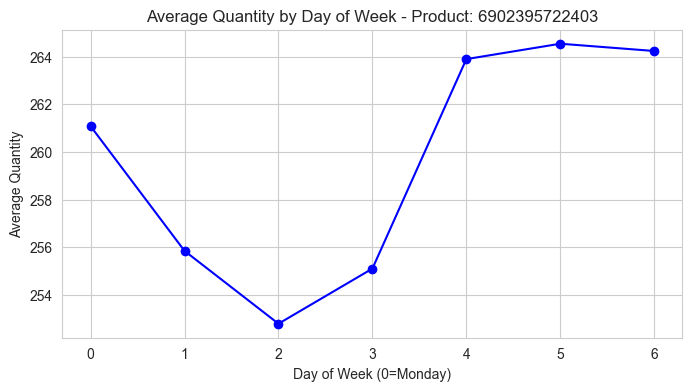

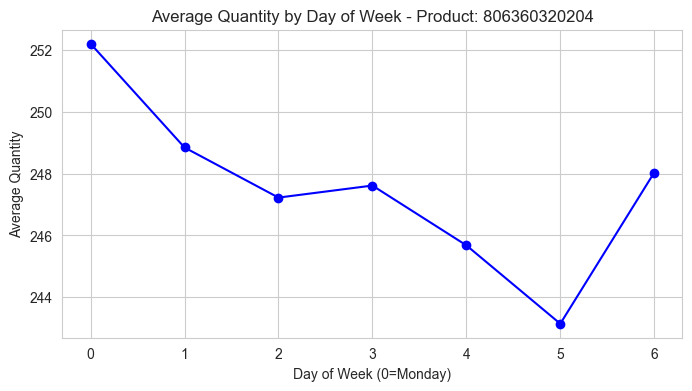

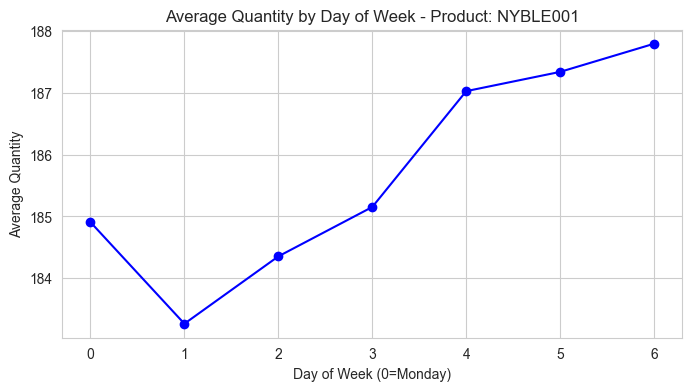

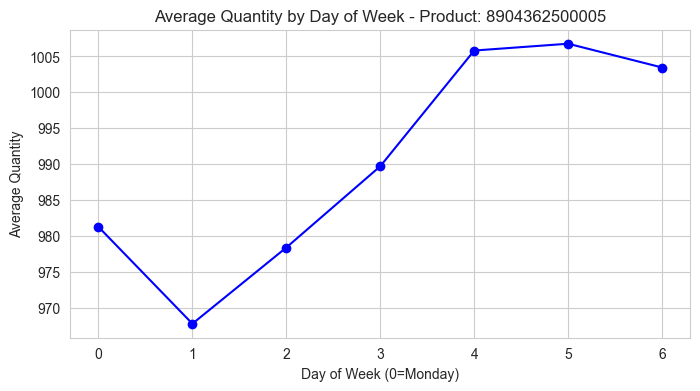

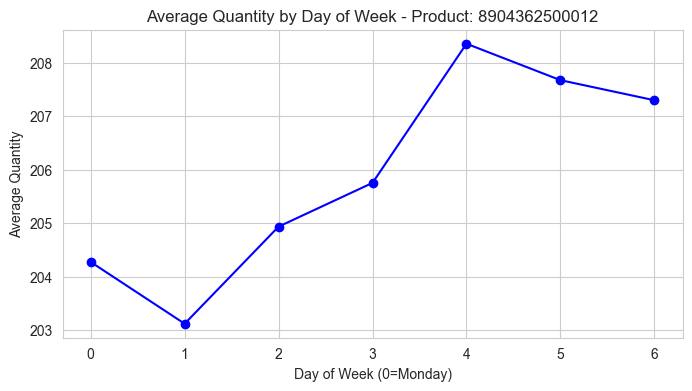

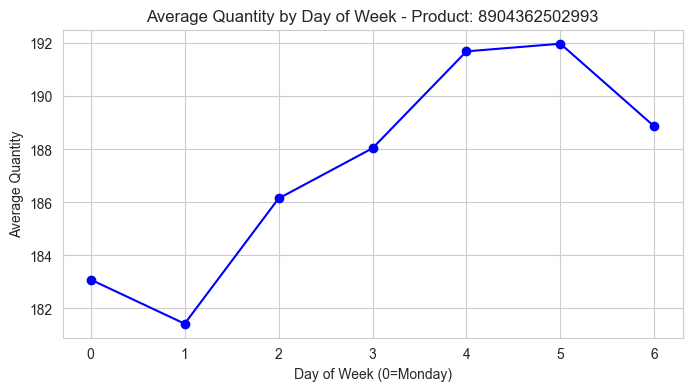

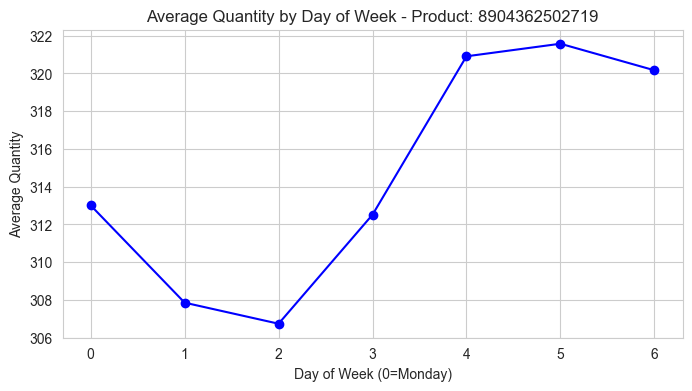

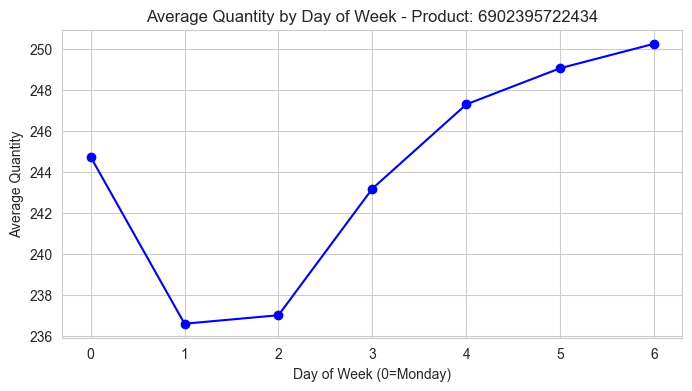

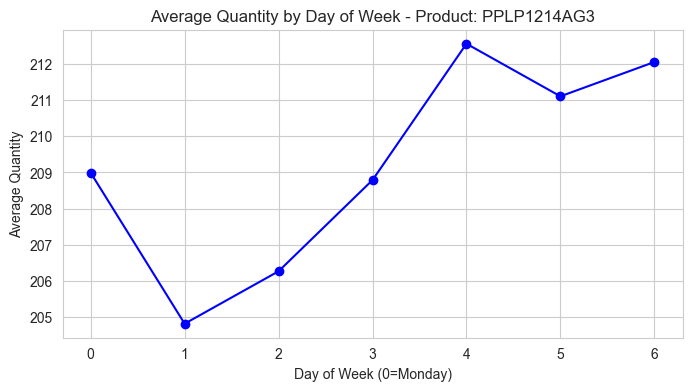

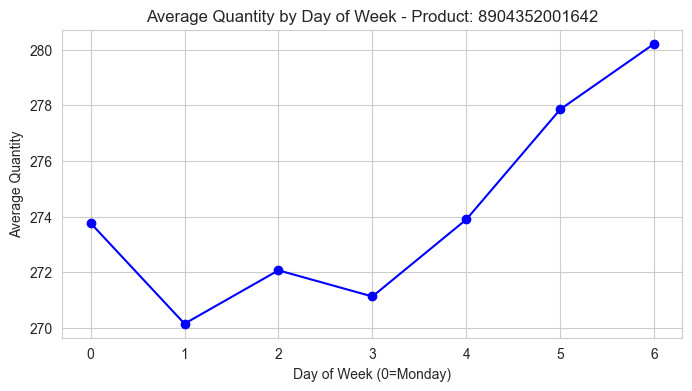

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

products_to_plot = df['ean_code'].unique()

for prod in products_to_plot:
    prod_data = df[df['ean_code'] == prod]
    weekly_avg = prod_data.groupby('dayofweek')['quantity'].mean()
    
    plt.figure(figsize=(8, 4))
    plt.plot(weekly_avg.index, weekly_avg.values, marker='o', linestyle='-', color='b')
    plt.title(f'Average Quantity by Day of Week - Product: {prod}')
    plt.xlabel('Day of Week (0=Monday)')
    plt.ylabel('Average Quantity')
    plt.xticks(range(7))
    plt.grid(True)
    plt.show()



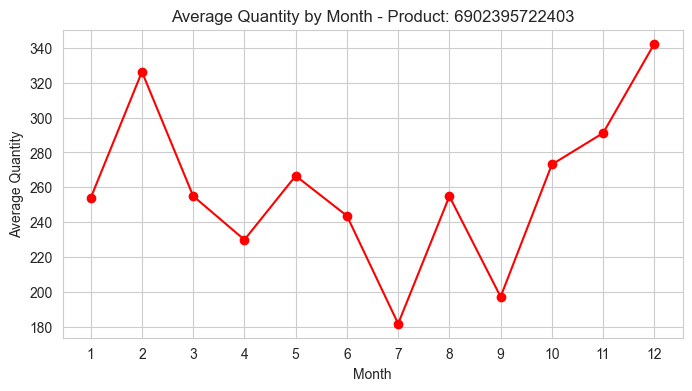

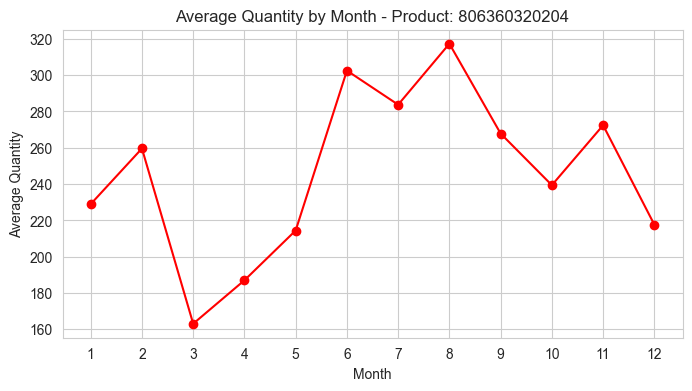

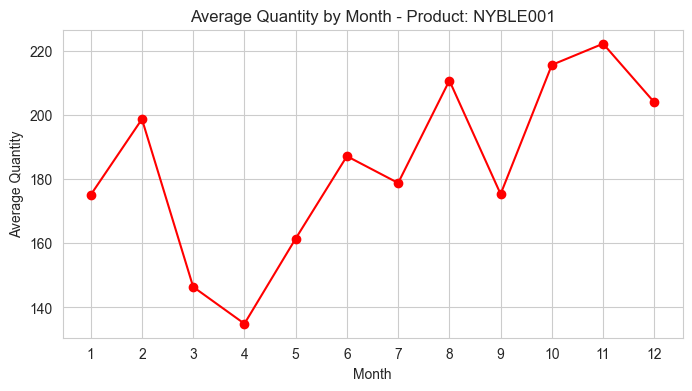

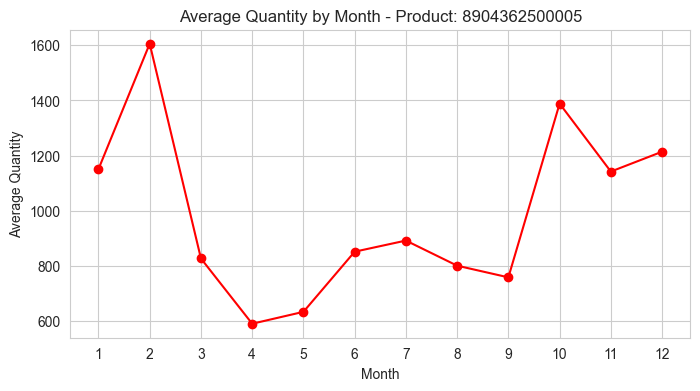

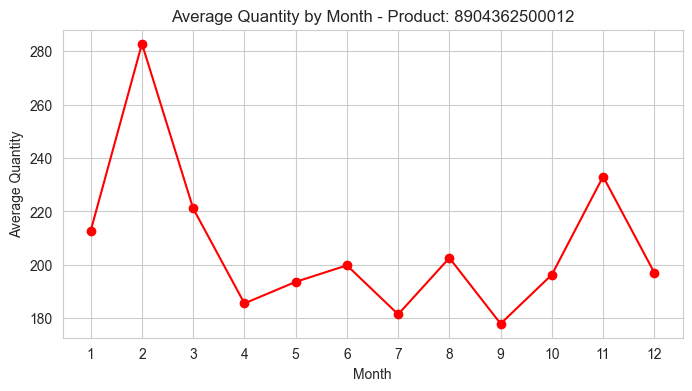

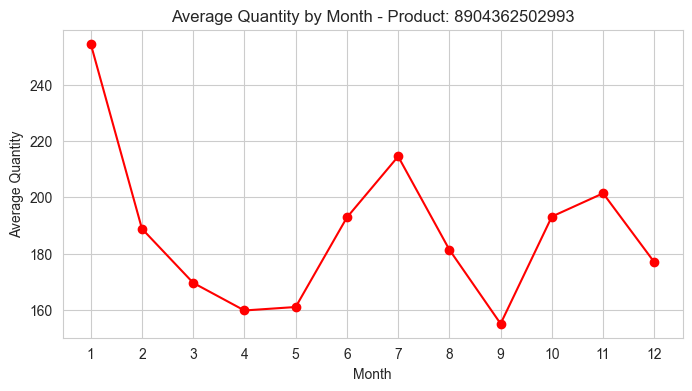

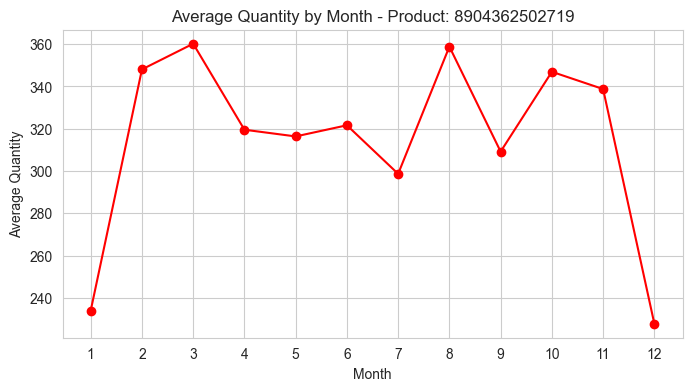

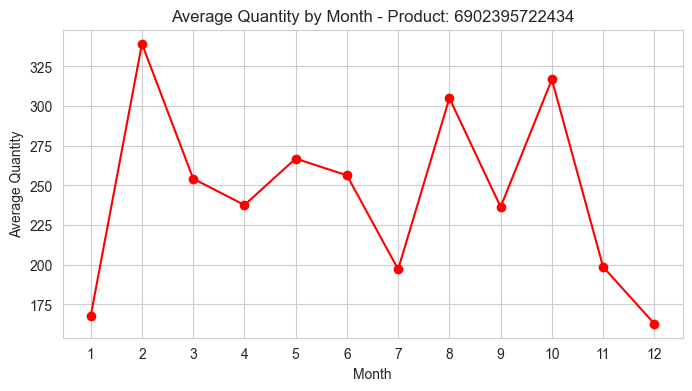

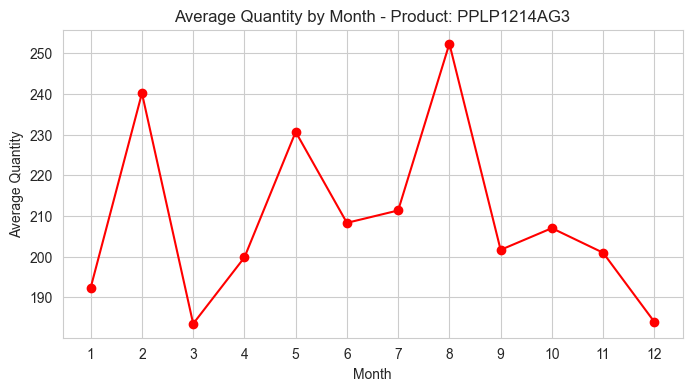

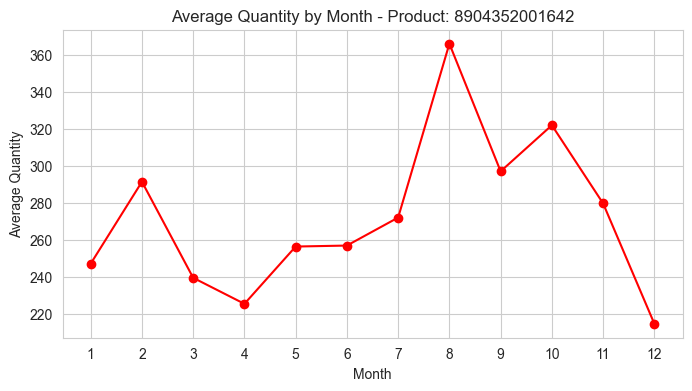

In [34]:
for prod in products_to_plot:
    prod_data = df[df['ean_code'] == prod]
    monthly_avg = prod_data.groupby('month')['quantity'].mean()
    
    plt.figure(figsize=(8, 4))
    plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-', color='r')
    plt.title(f'Average Quantity by Month - Product: {prod}')
    plt.xlabel('Month')
    plt.ylabel('Average Quantity')
    plt.xticks(range(1,13))
    plt.grid(True)
    plt.show()


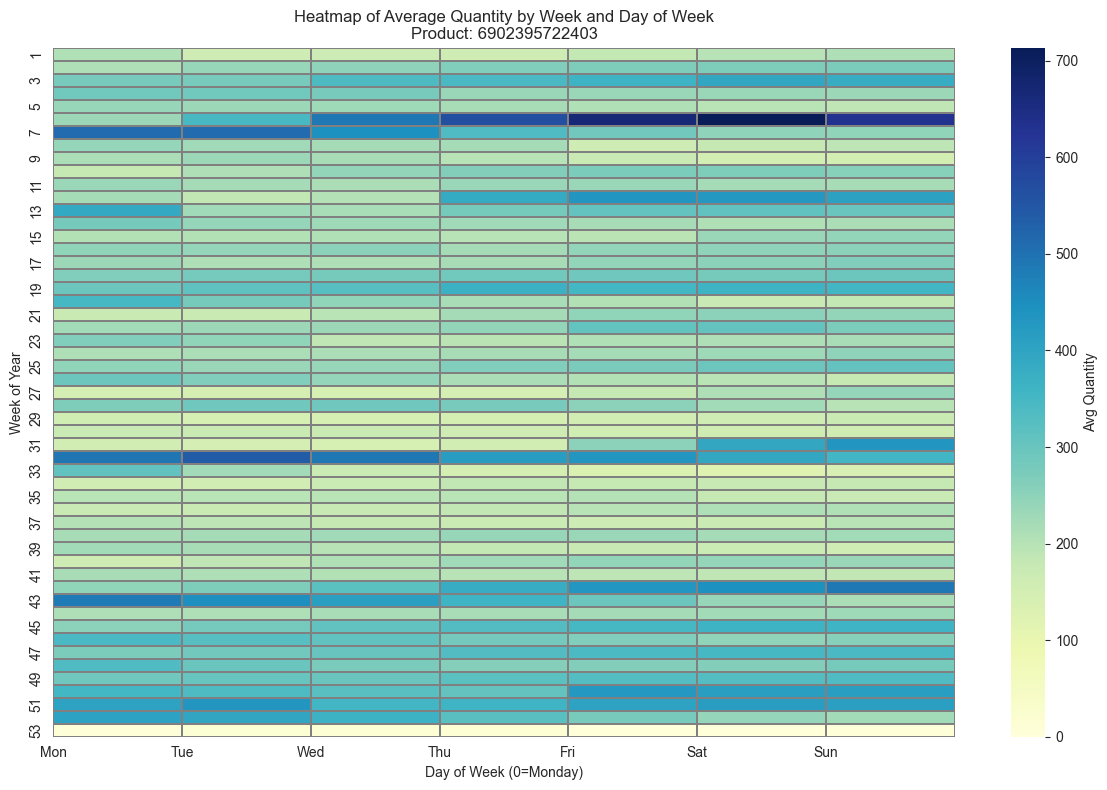

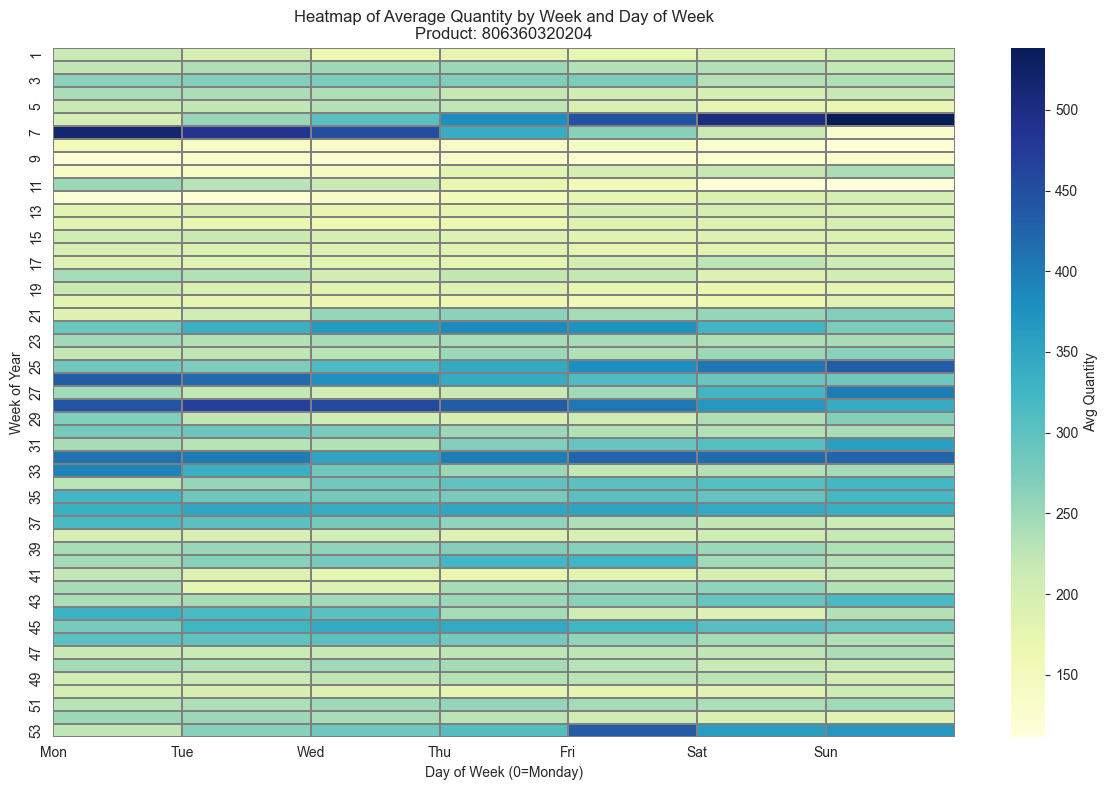

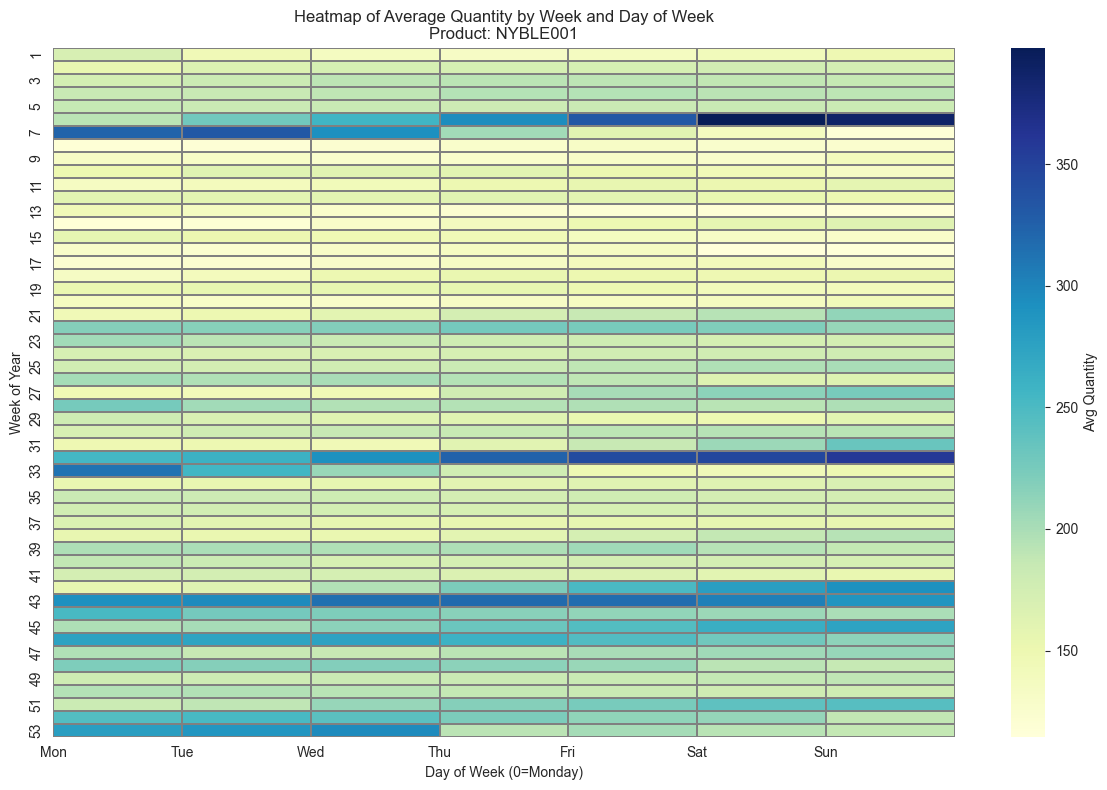

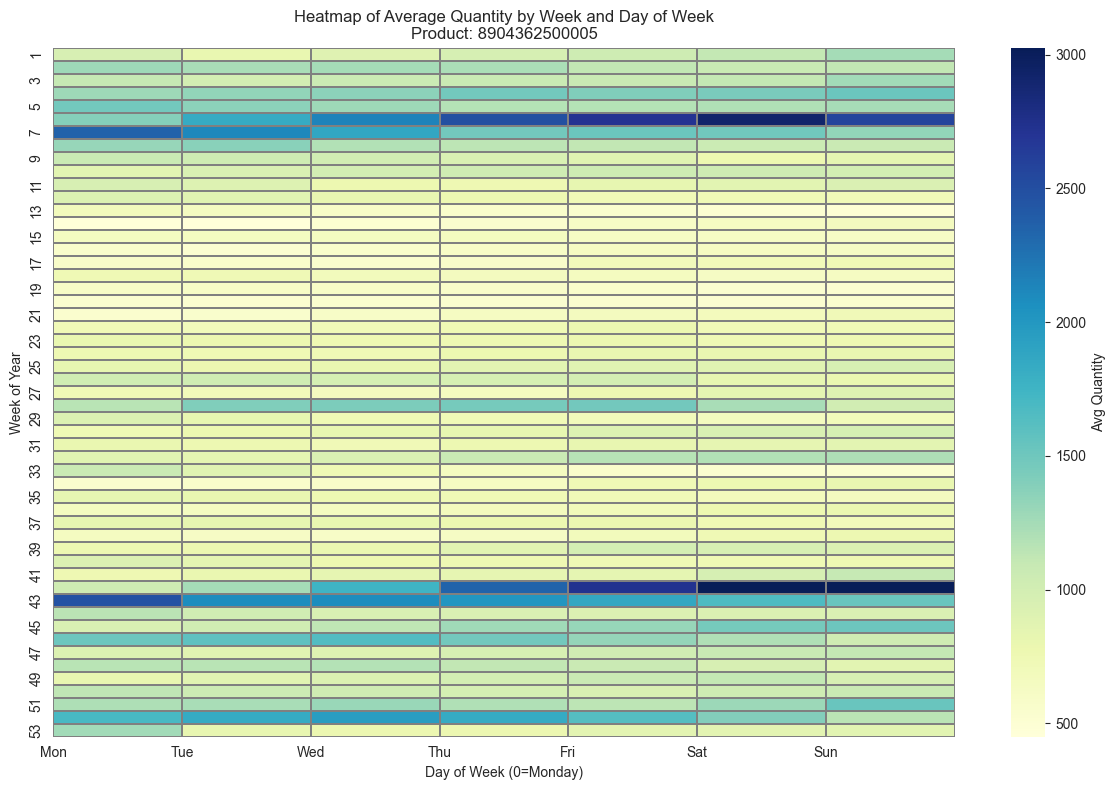

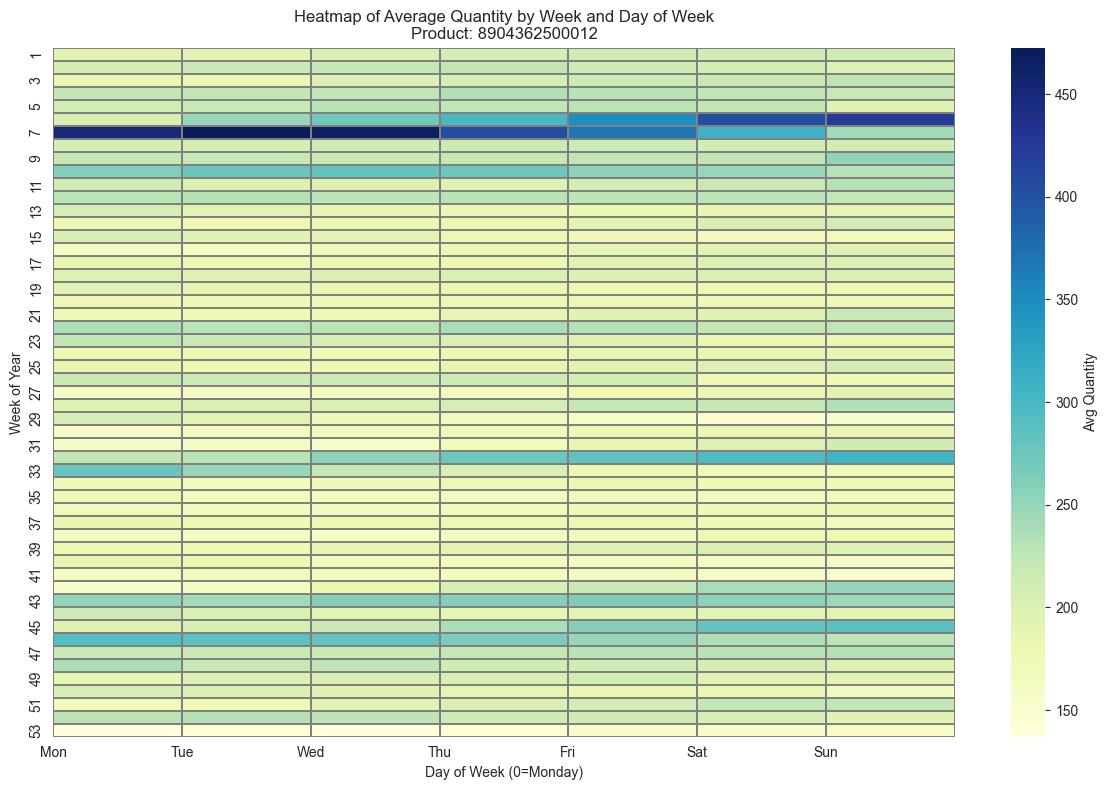

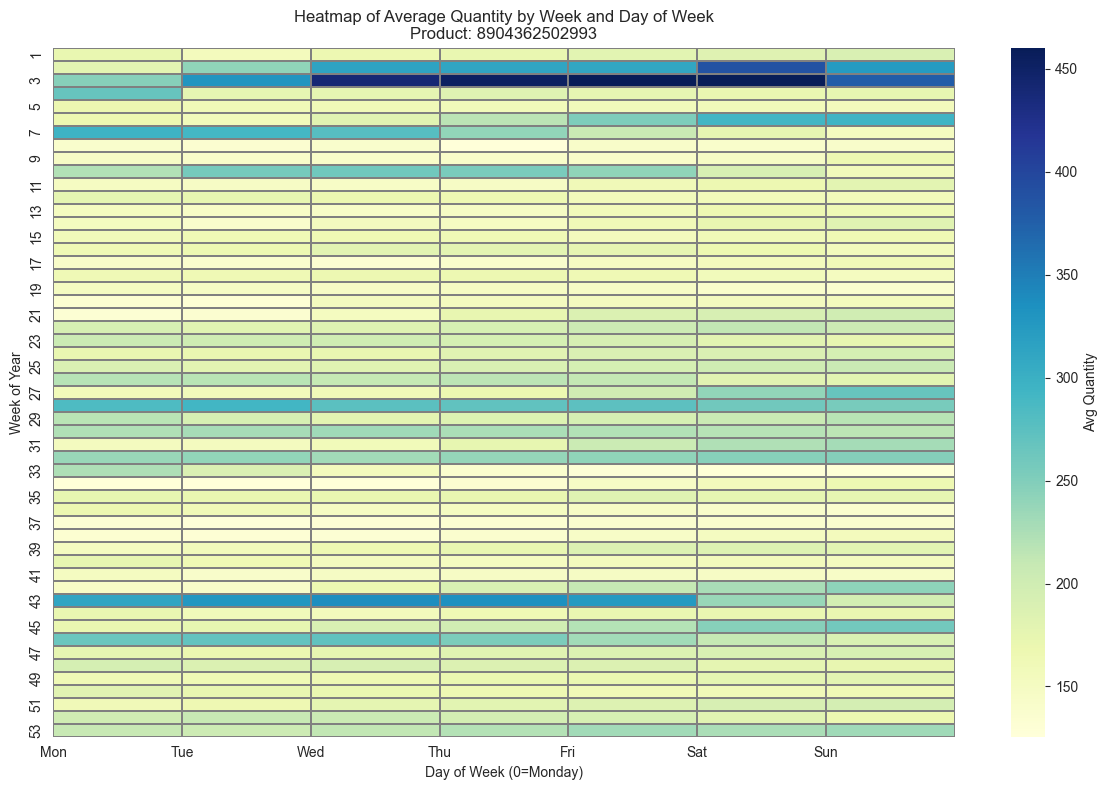

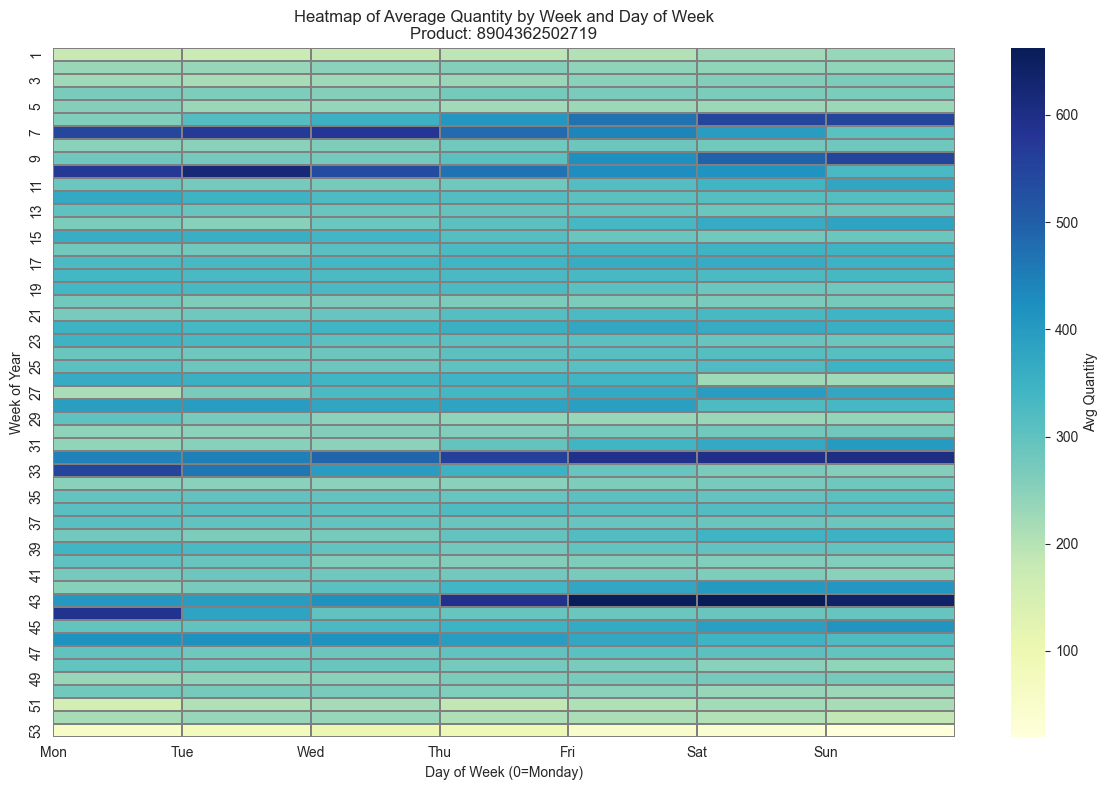

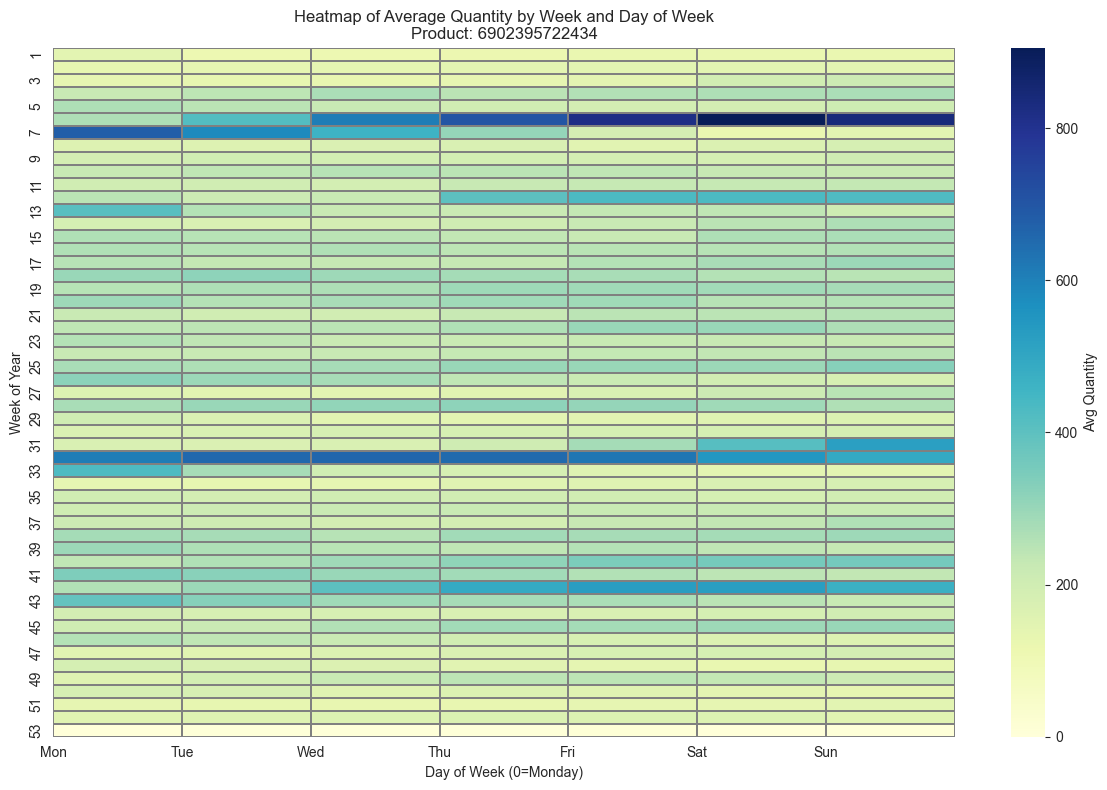

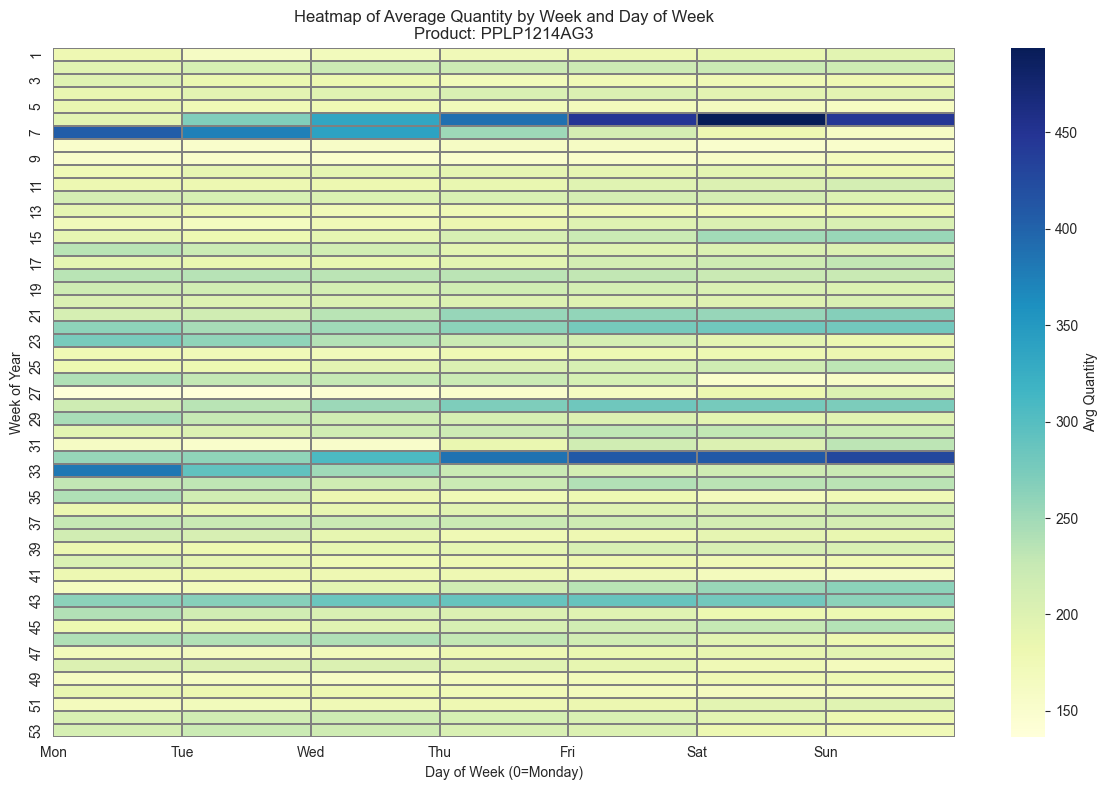

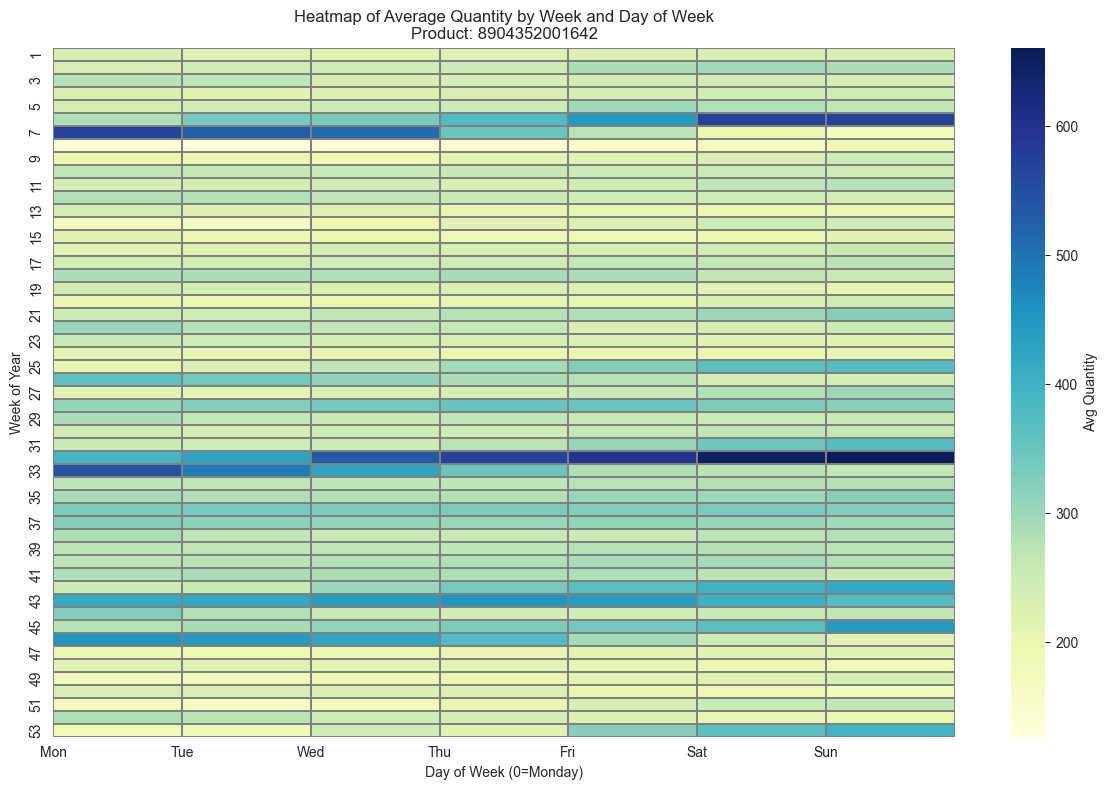

In [35]:
for prod in products_to_plot:
    prod_data = df[df['ean_code'] == prod].copy()
    # Extract week of year and day of week
    prod_data['weekofyear'] = prod_data['order_date'].dt.isocalendar().week.astype(int)
    prod_data['dayofweek'] = prod_data['order_date'].dt.dayofweek
    
    # Create pivot table: rows=week of year, columns=day of week, values=mean quantity
    pivot = prod_data.pivot_table(index='weekofyear', columns='dayofweek', values='quantity', aggfunc='mean')
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot, cmap='YlGnBu', linecolor='gray', linewidths=0.3, cbar_kws={'label': 'Avg Quantity'})
    
    plt.title(f'Heatmap of Average Quantity by Week and Day of Week\nProduct: {prod}')
    plt.xlabel('Day of Week (0=Monday)')
    plt.ylabel('Week of Year')
    
    # Optional: set x-axis labels to short names
    plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
    
    plt.tight_layout()
    plt.show()

In [36]:
import holidays
years = df['order_date'].dt.year.unique()
ind_holidays = holidays.India(years=years)
df['order_date'] = df['order_date'].dt.date

df['is_holiday'] = df['order_date'].isin(ind_holidays).astype(int)
df['is_day_before_holiday'] = df['order_date'].shift(-1).isin(ind_holidays).astype(int)
df['is_day_after_holiday'] = df['order_date'].shift(1).isin(ind_holidays).astype(int)

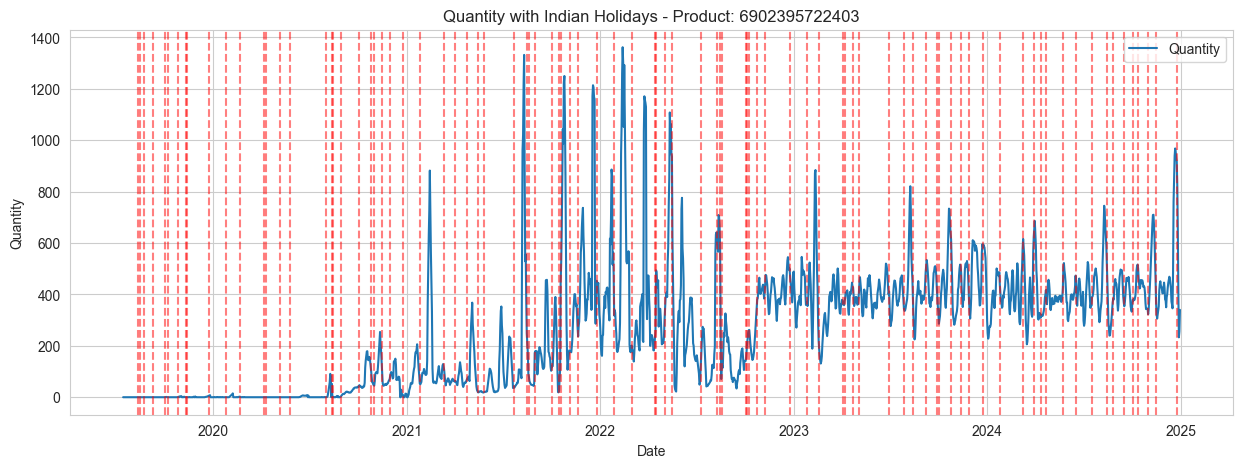

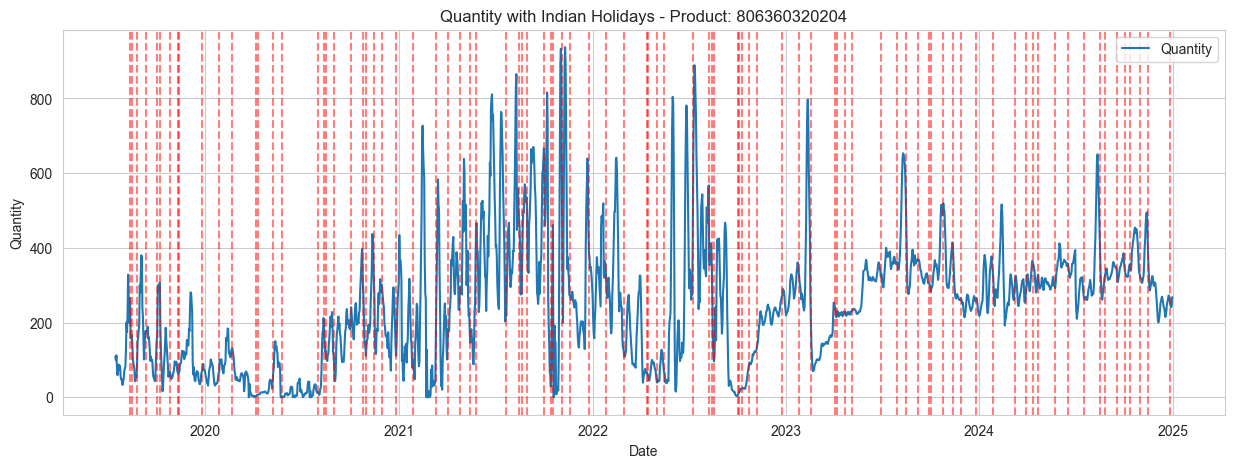

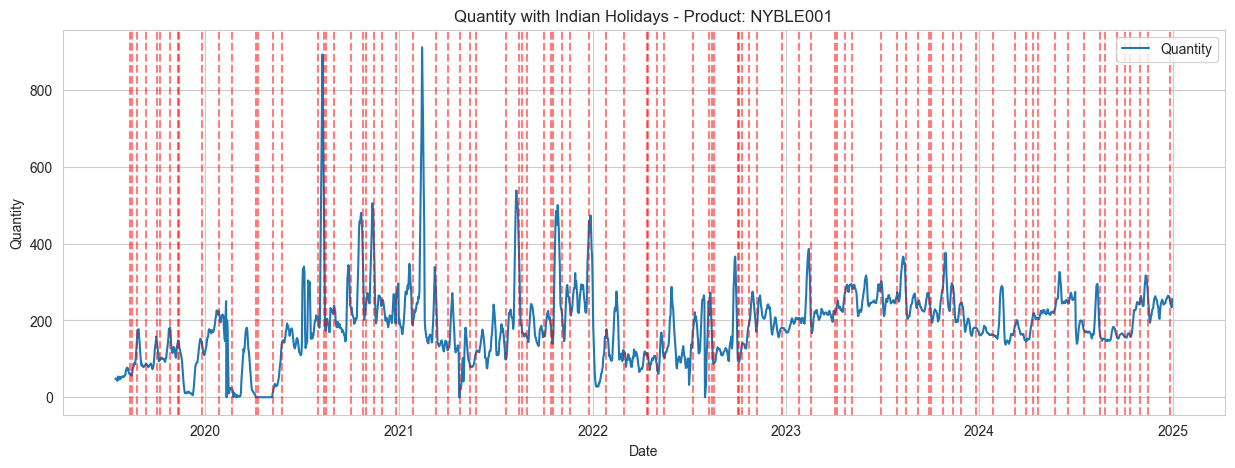

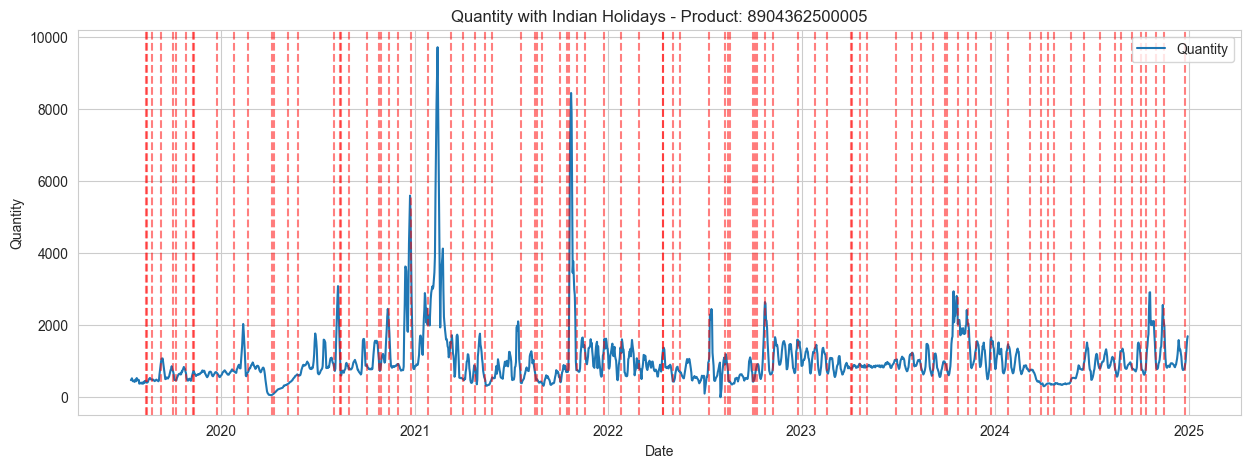

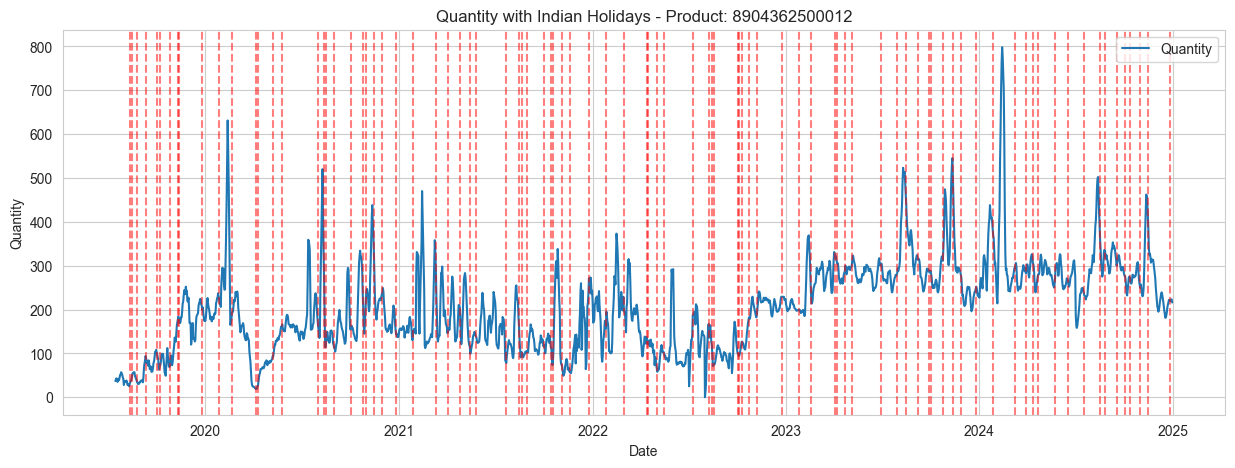

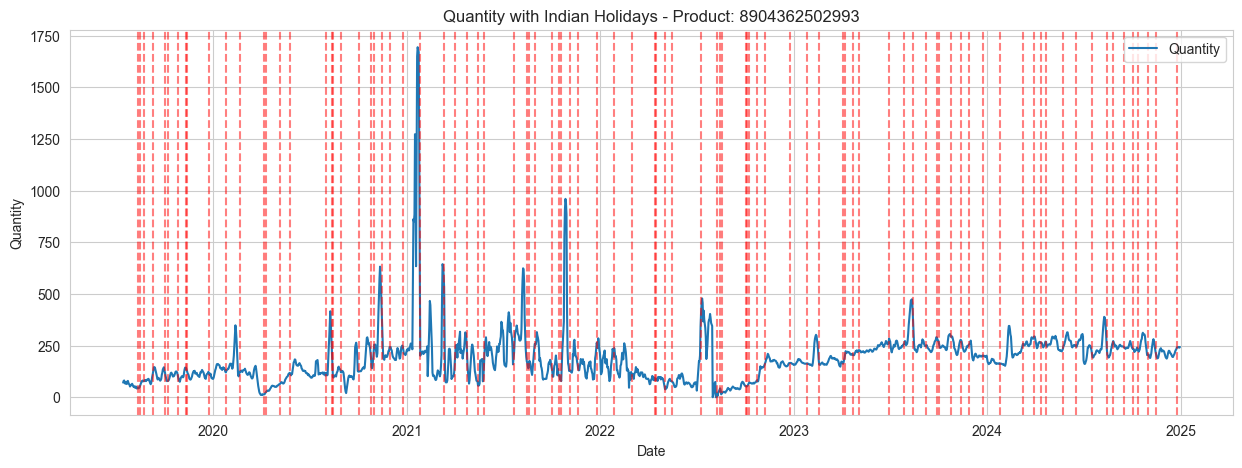

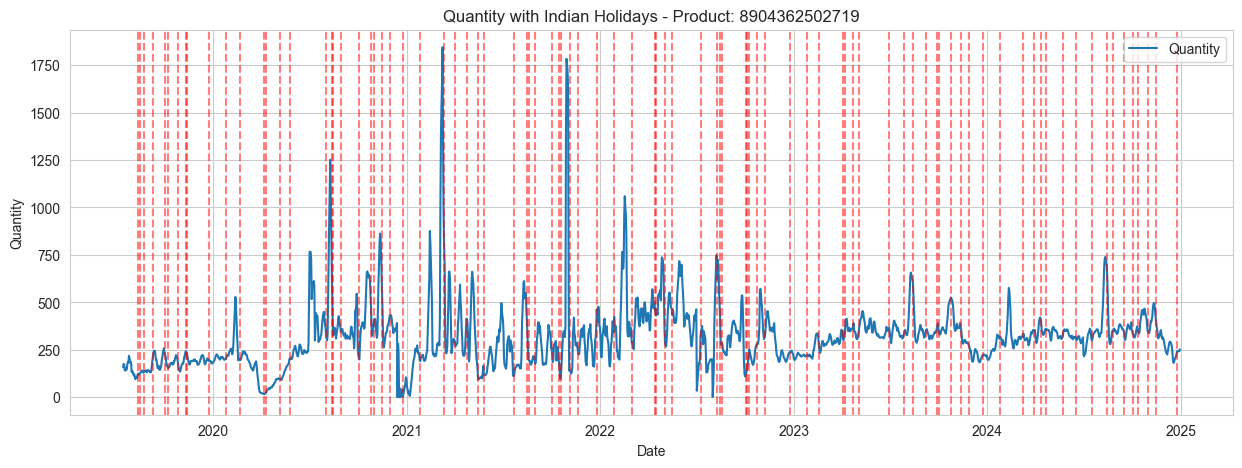

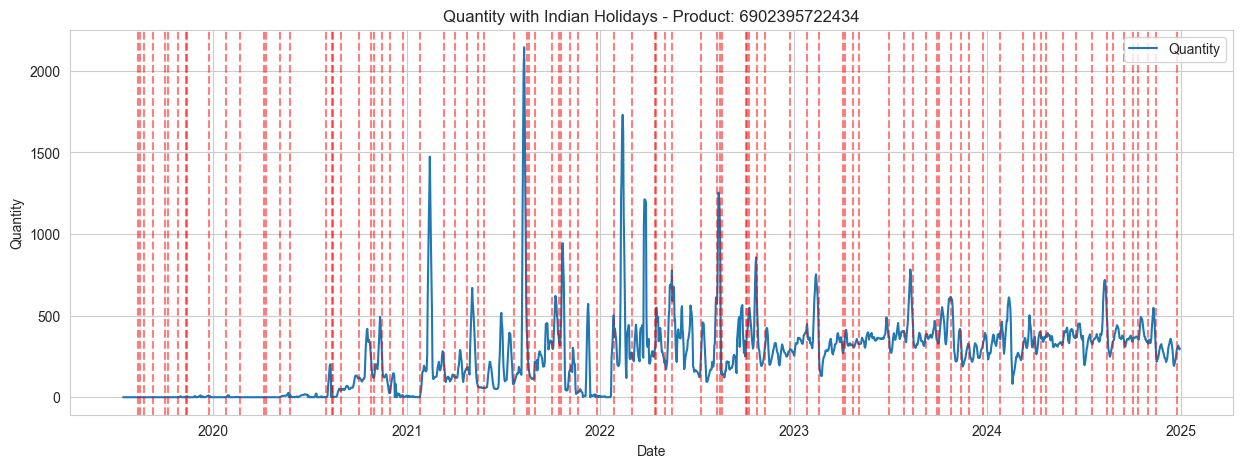

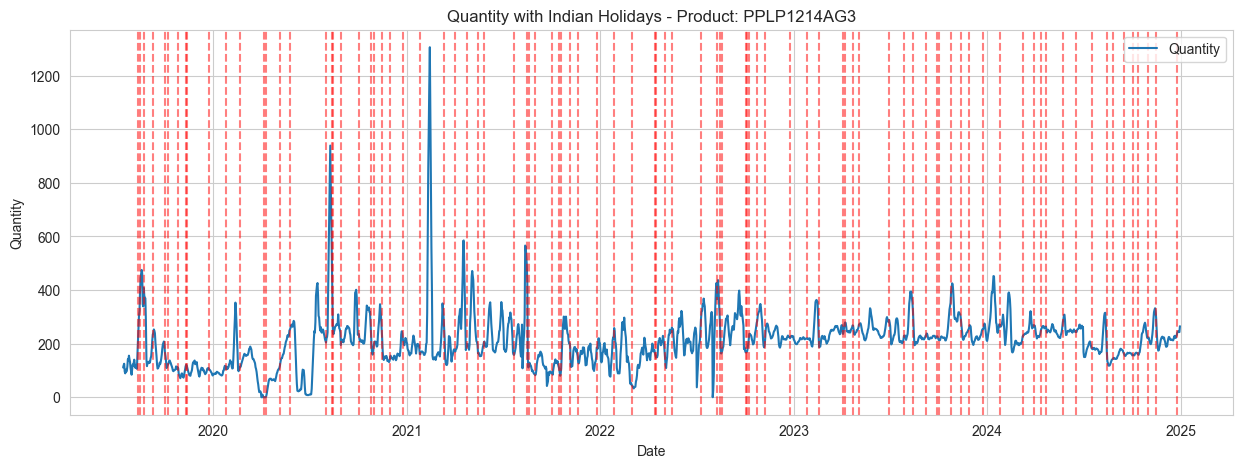

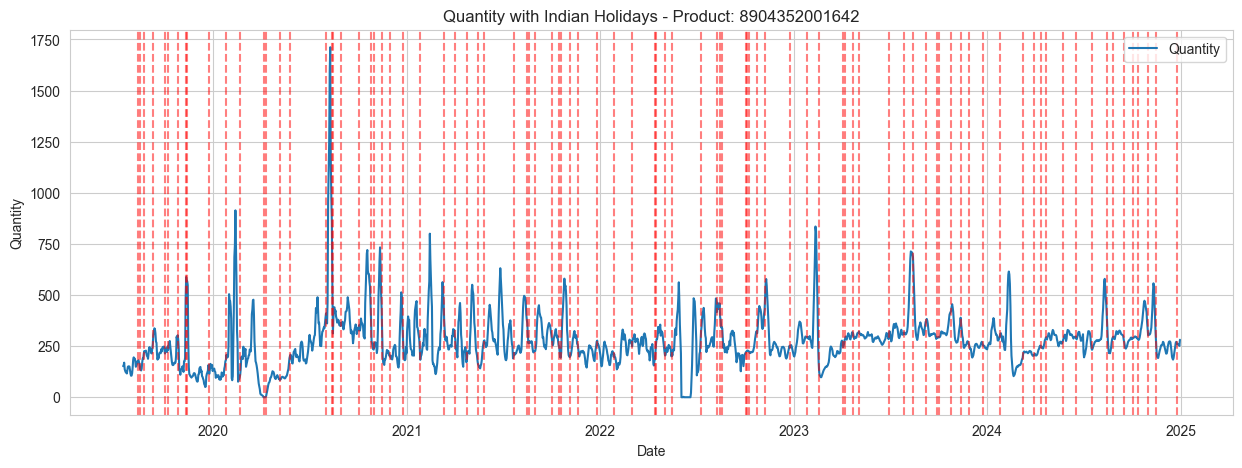

In [37]:
import matplotlib.pyplot as plt
for prod in products_to_plot:
    prod_data = df[df['ean_code'] == prod].copy()

    plt.figure(figsize=(15, 5))
    plt.plot(prod_data['order_date'], prod_data['quantity'], label='Quantity')

    holiday_dates = prod_data[prod_data['is_holiday'] == 1]['order_date']
    for hdate in holiday_dates:
        plt.axvline(hdate, color='red', linestyle='--', alpha=0.5)
    
    plt.title(f'Quantity with Indian Holidays - Product: {prod}')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()


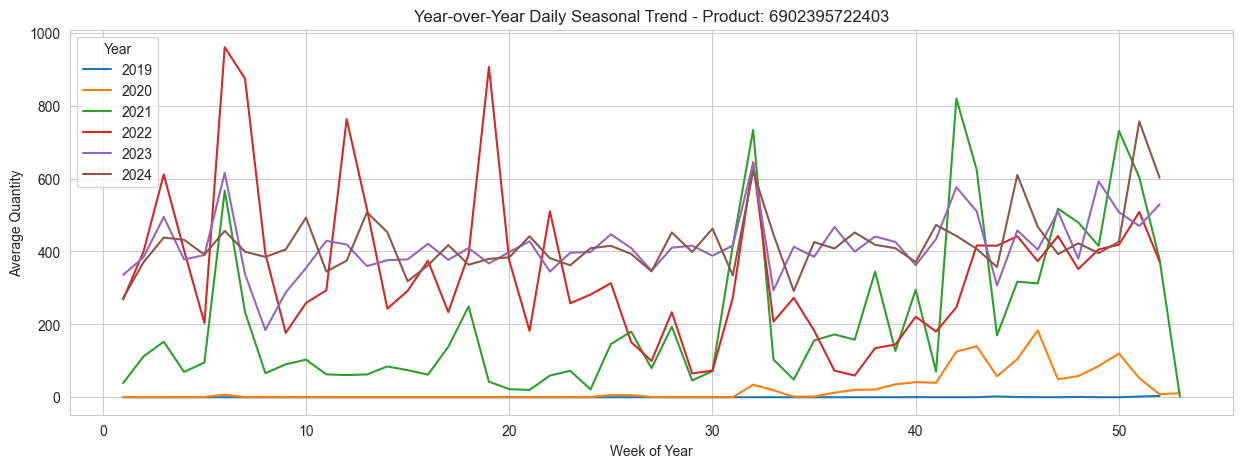

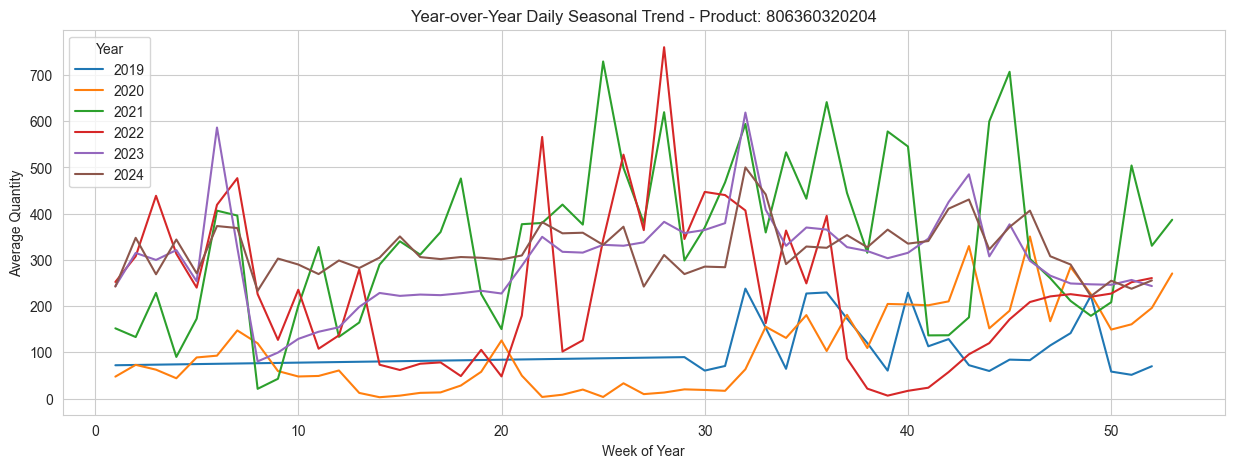

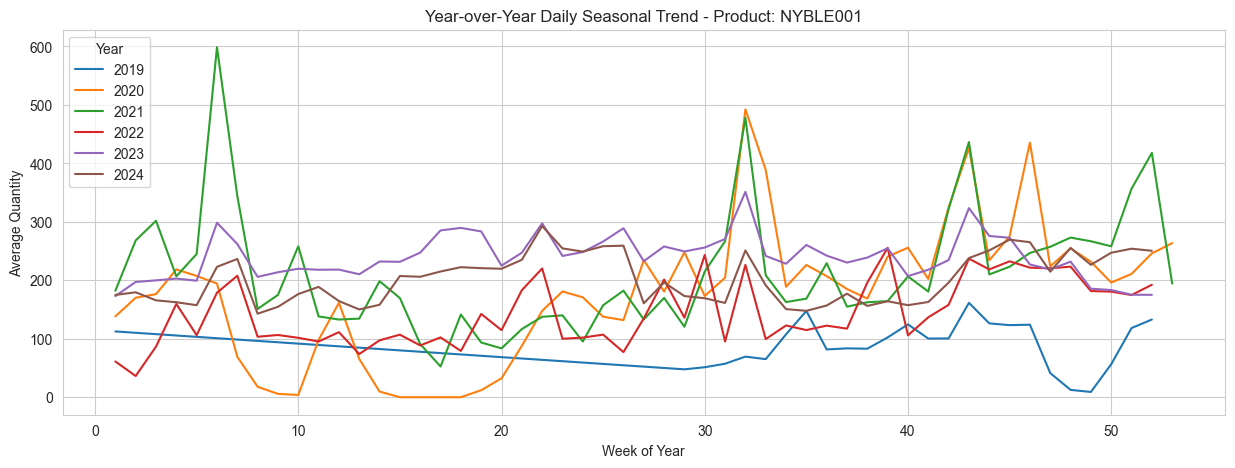

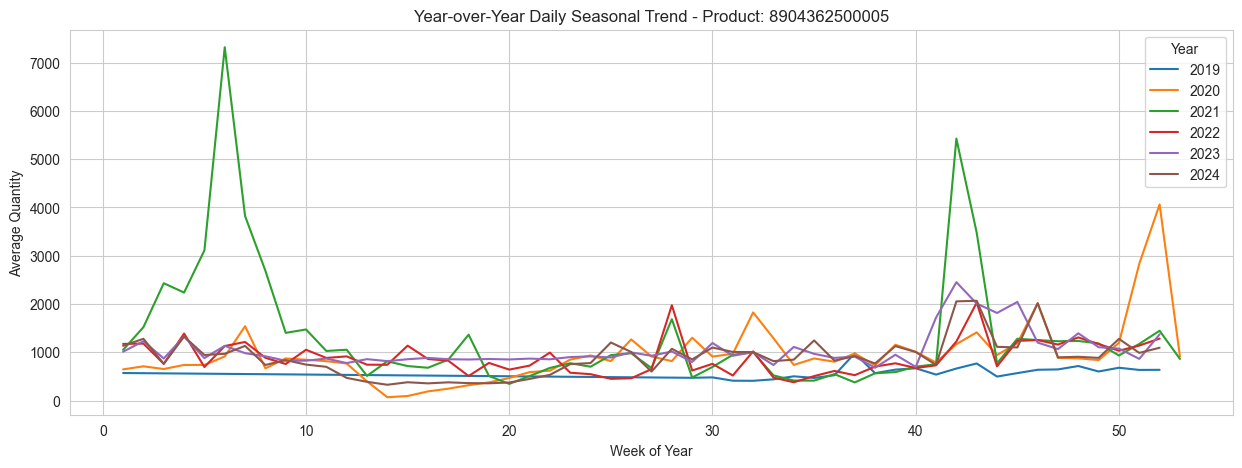

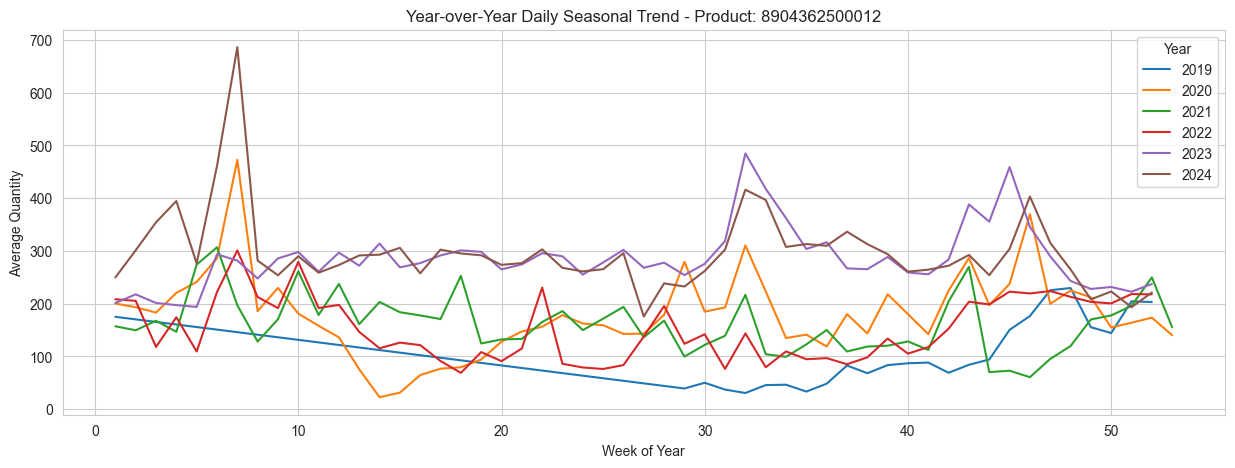

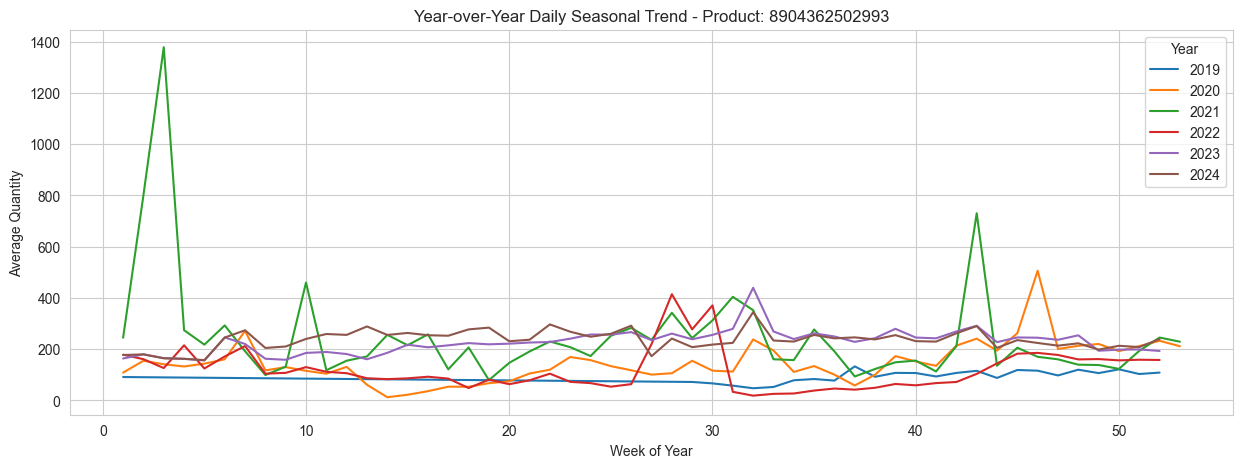

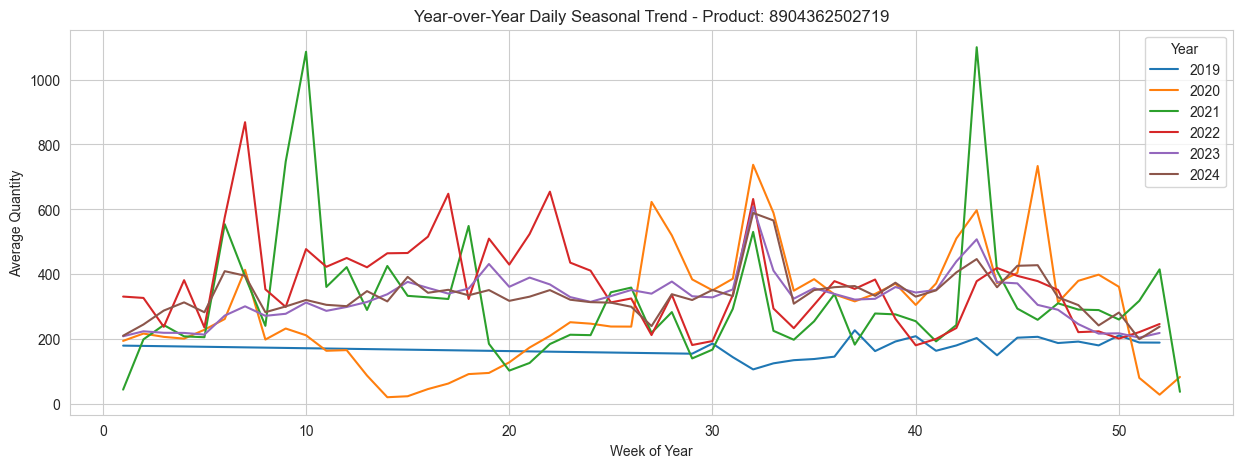

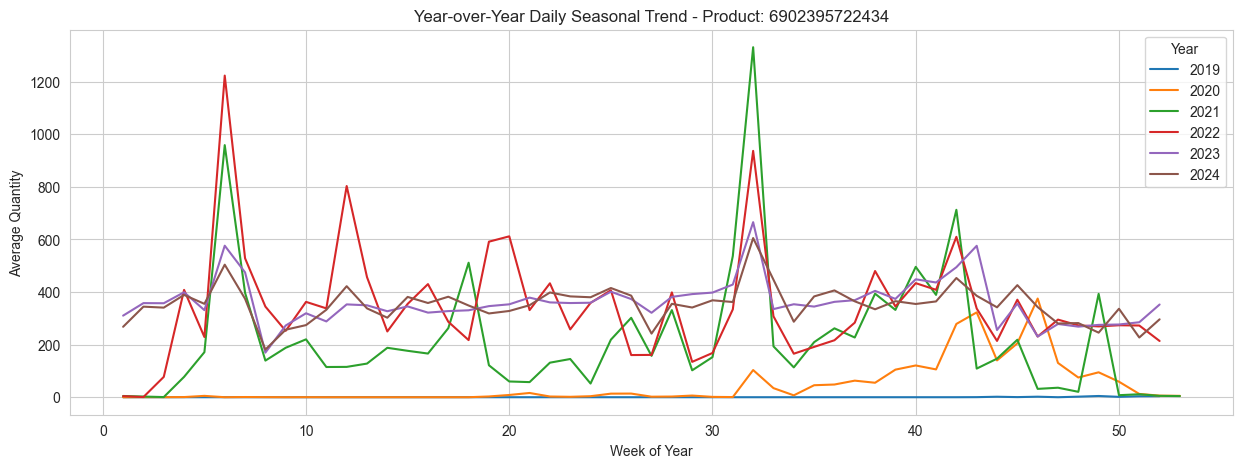

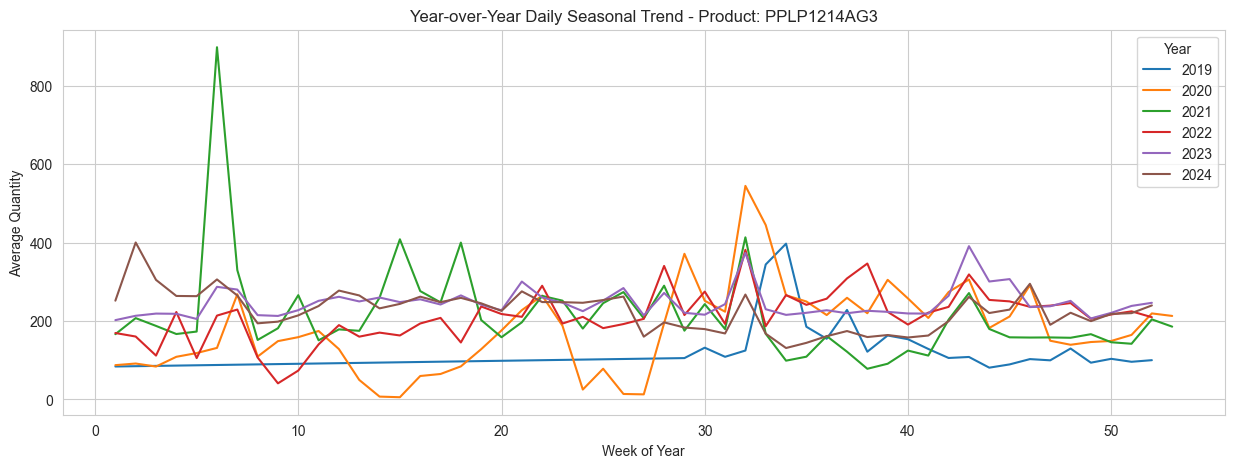

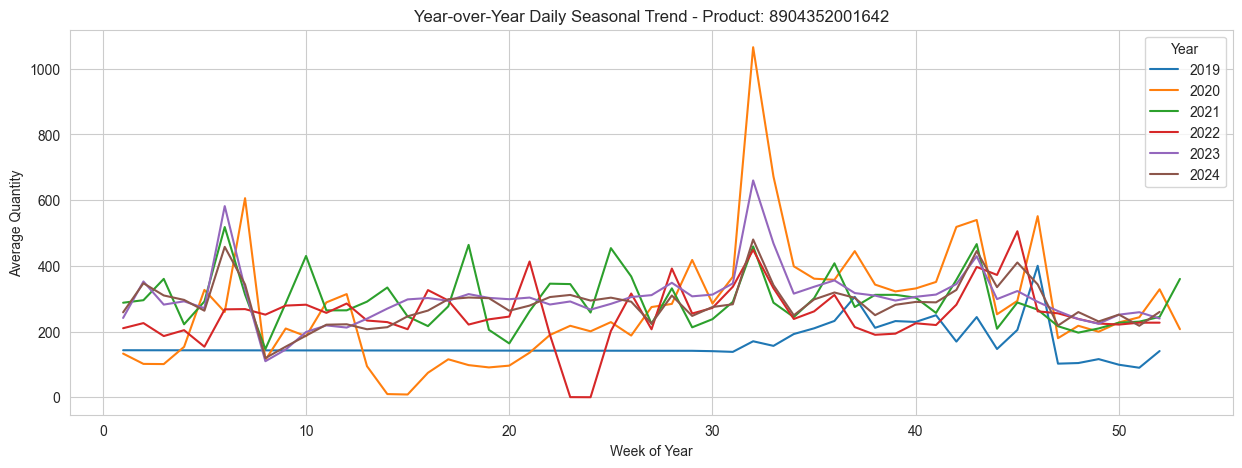

In [38]:
for prod in products_to_plot:
    df['order_date'] = pd.to_datetime(df['order_date'])
    prod_data = df[df['ean_code'] == prod].copy()
    prod_data['year'] = prod_data['order_date'].dt.year
    prod_data['weekofyear'] = prod_data['order_date'].dt.isocalendar().week
    
    plt.figure(figsize=(15, 5))
    for year in sorted(prod_data['year'].unique()):
        yearly_data = prod_data[prod_data['year'] == year]
        daily_avg = yearly_data.groupby('weekofyear')['quantity'].mean()
        plt.plot(daily_avg.index, daily_avg.values, label=str(year))
    
    plt.title(f'Year-over-Year Daily Seasonal Trend - Product: {prod}')
    plt.xlabel('Week of Year')
    plt.ylabel('Average Quantity')
    plt.legend(title='Year')
    plt.show()


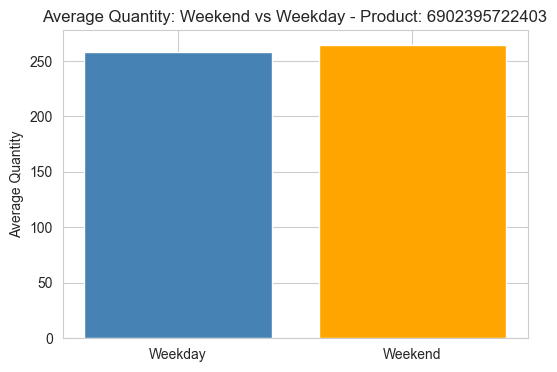

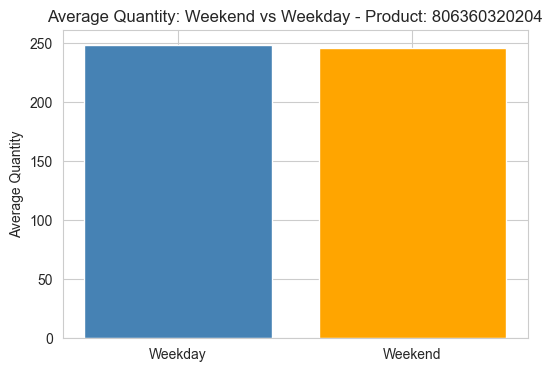

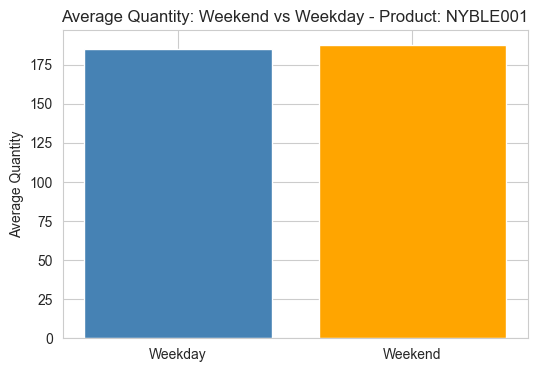

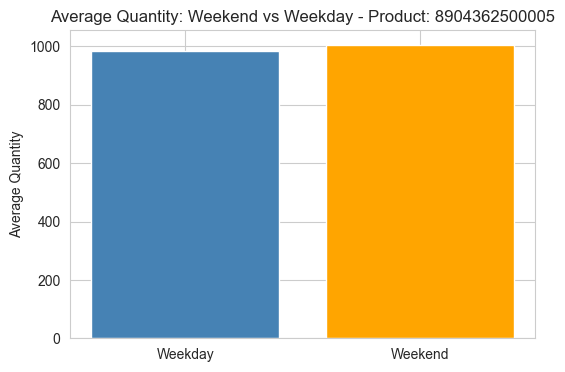

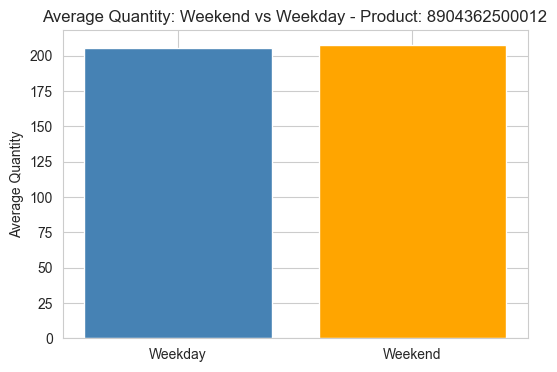

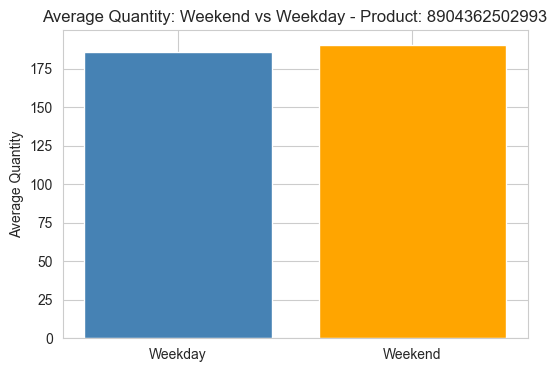

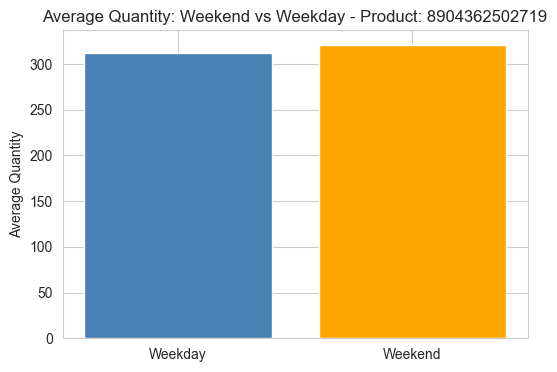

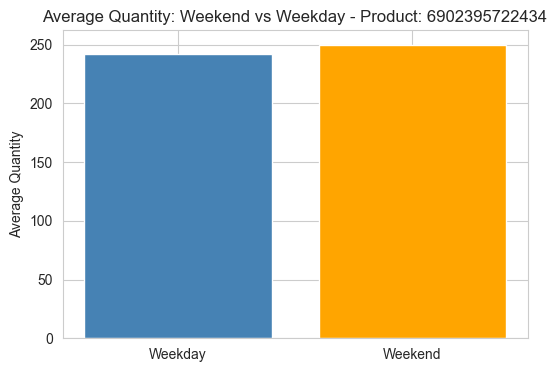

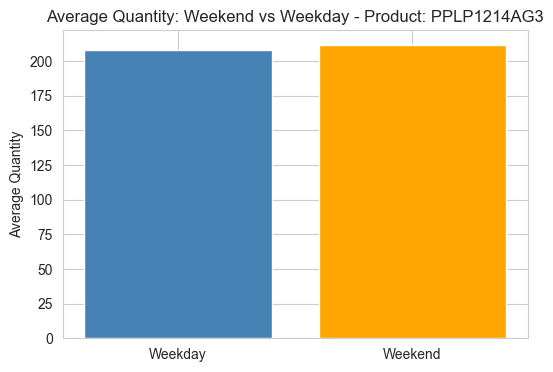

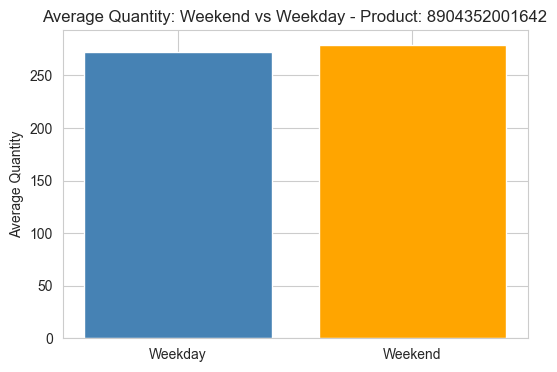

In [39]:
for prod in products_to_plot:
    prod_data = df[df['ean_code'] == prod].copy()
    prod_data['is_weekend'] = (prod_data['order_date'].dt.dayofweek >= 5).astype(int)
    
    avg_weekend = prod_data[prod_data['is_weekend'] == 1]['quantity'].mean()
    avg_weekday = prod_data[prod_data['is_weekend'] == 0]['quantity'].mean()
    
    plt.figure(figsize=(6,4))
    plt.bar(['Weekday', 'Weekend'], [avg_weekday, avg_weekend], color=['steelblue', 'orange'])
    plt.title(f'Average Quantity: Weekend vs Weekday - Product: {prod}')
    plt.ylabel('Average Quantity')
    plt.show()


In [40]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['season'] = df['order_date'].dt.month.apply(get_season)

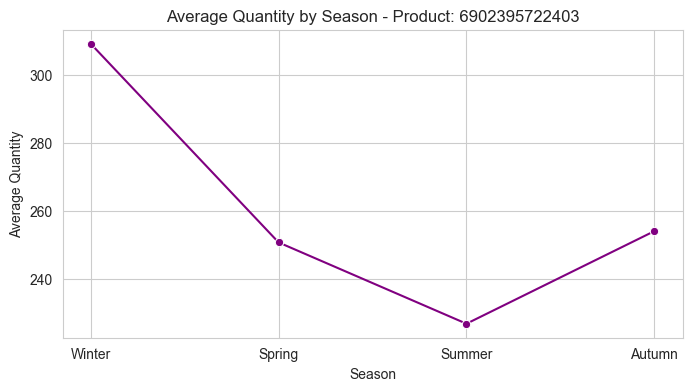

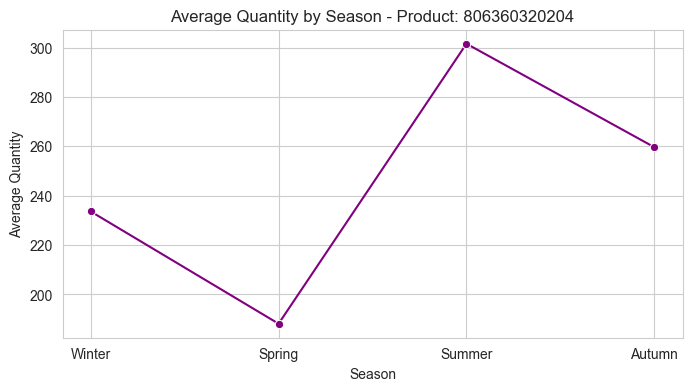

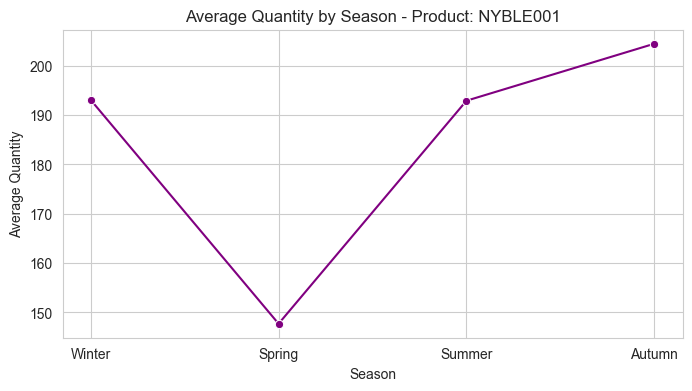

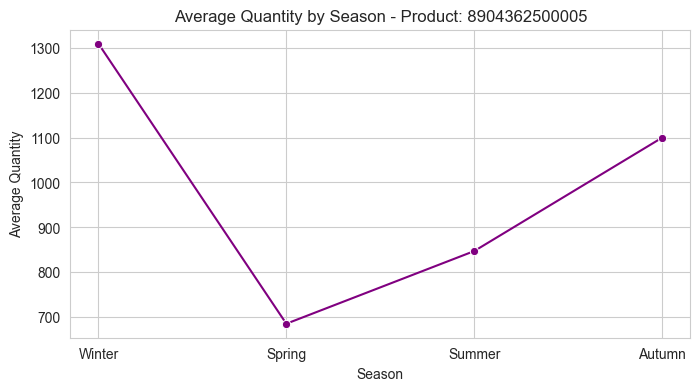

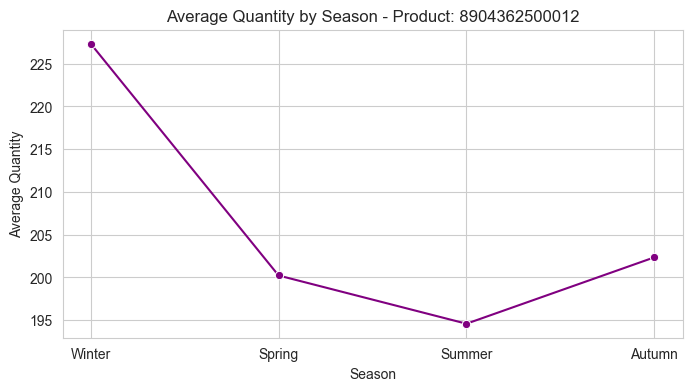

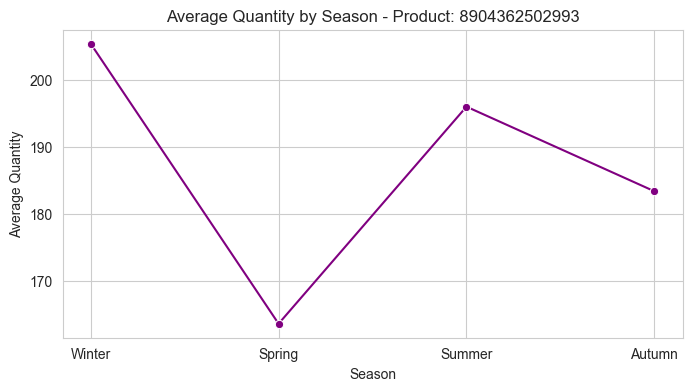

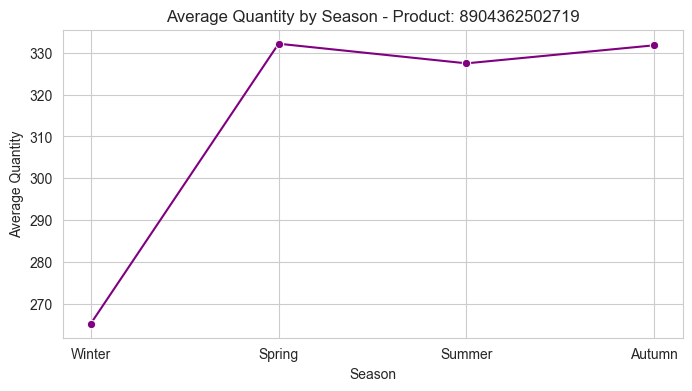

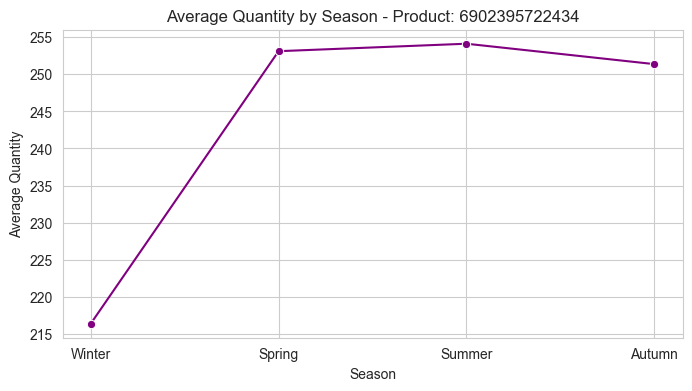

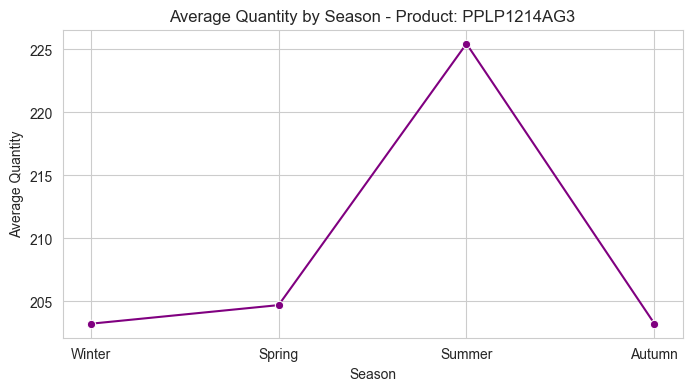

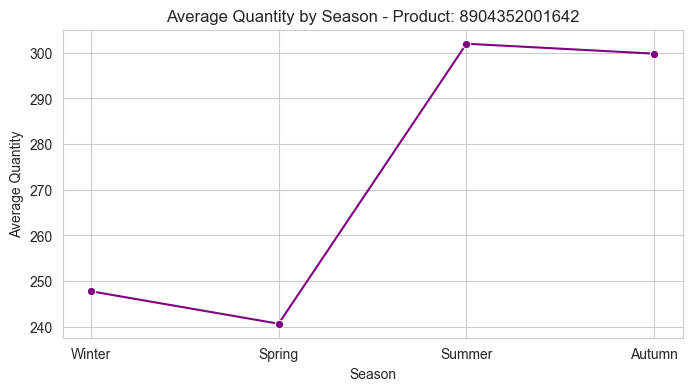

In [41]:
for prod in products_to_plot:
    prod_data = df[df['ean_code'] == prod]
    season_avg = prod_data.groupby('season')['quantity'].mean().reindex(['Winter', 'Spring', 'Summer', 'Autumn'])

    plt.figure(figsize=(8,4))
    sns.lineplot(x=season_avg.index, y=season_avg.values, marker='o', color='purple')
    plt.title(f'Average Quantity by Season - Product: {prod}')
    plt.xlabel('Season')
    plt.ylabel('Average Quantity')
    plt.grid(True)
    plt.show()


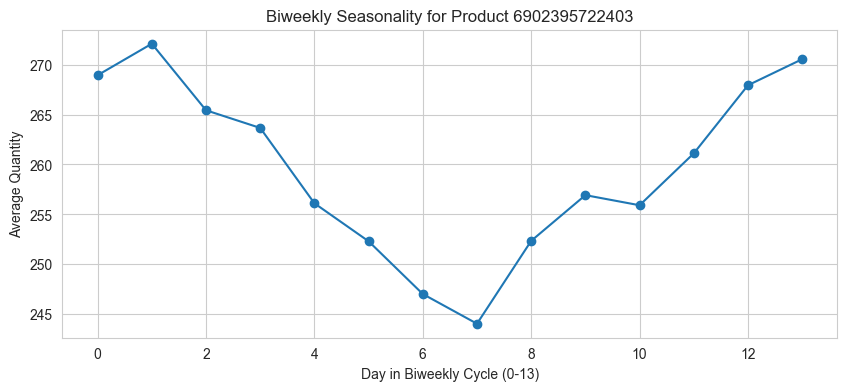

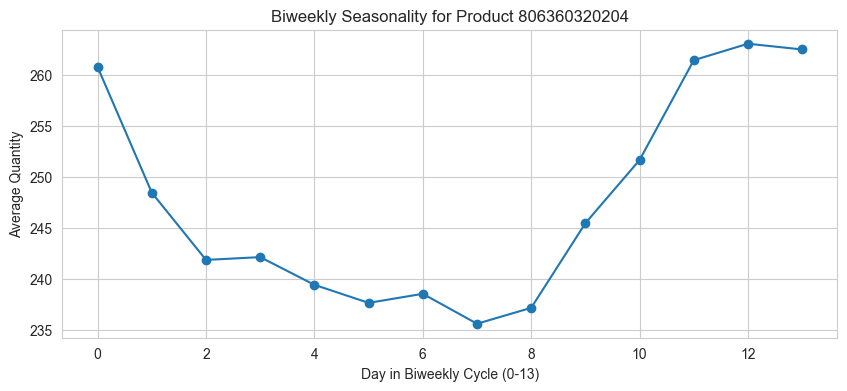

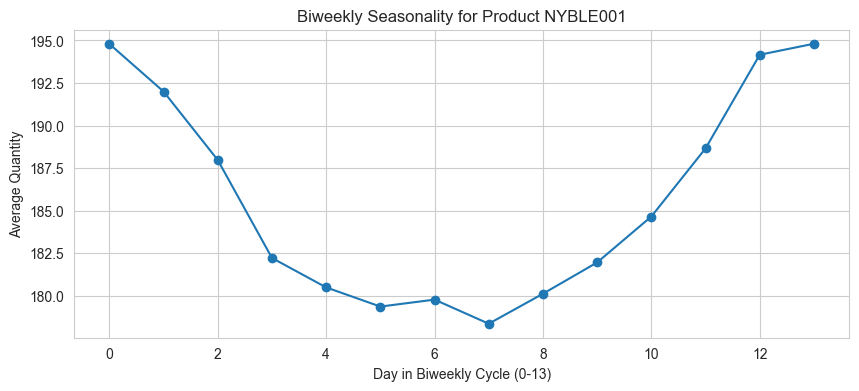

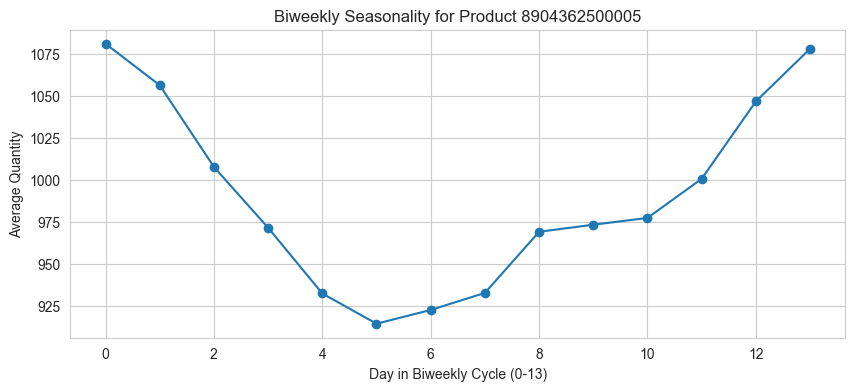

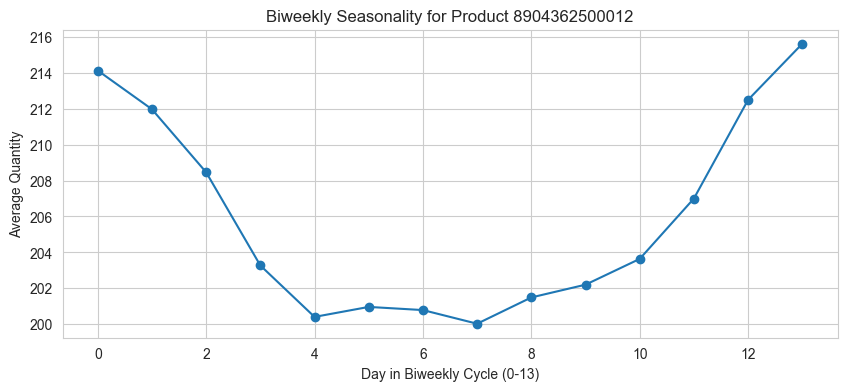

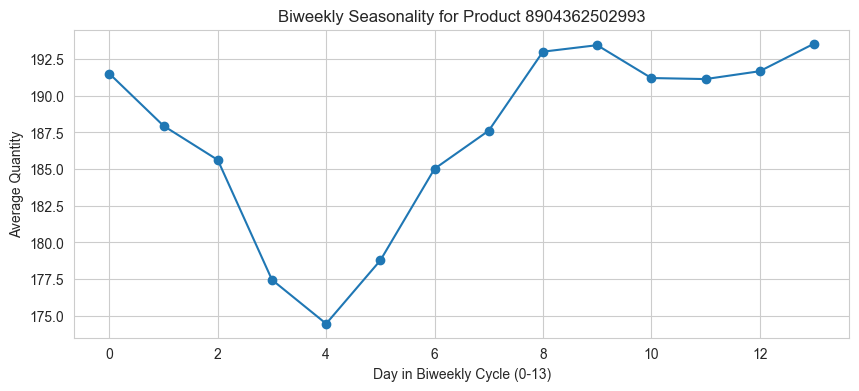

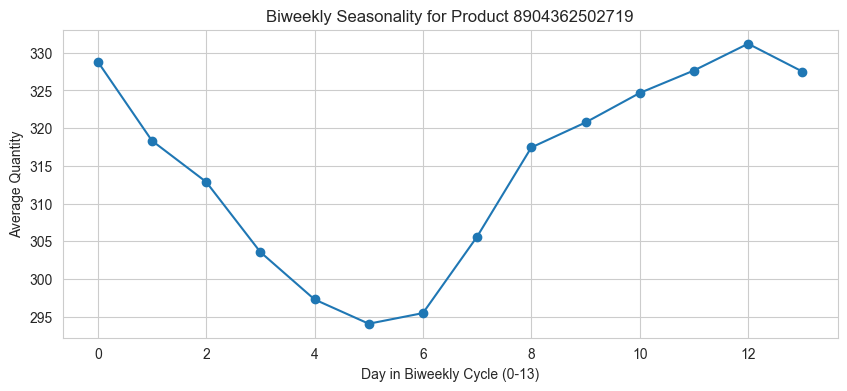

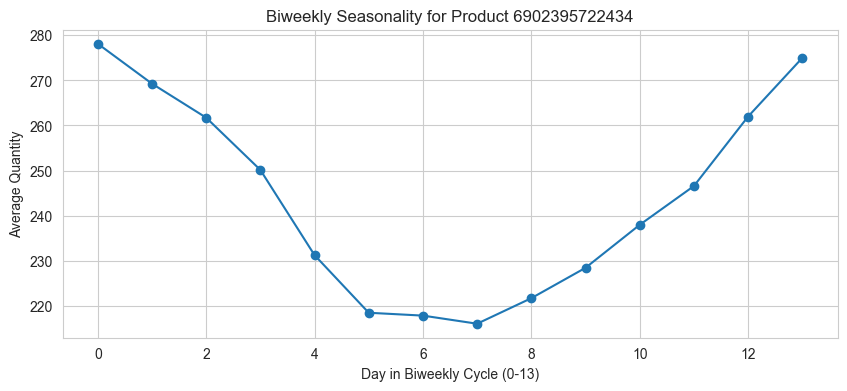

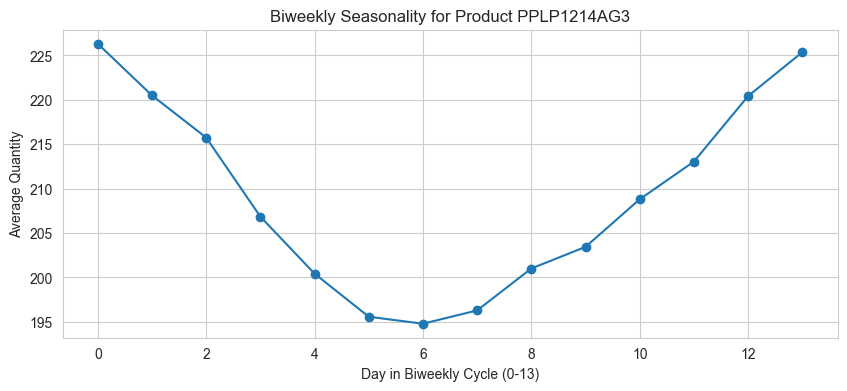

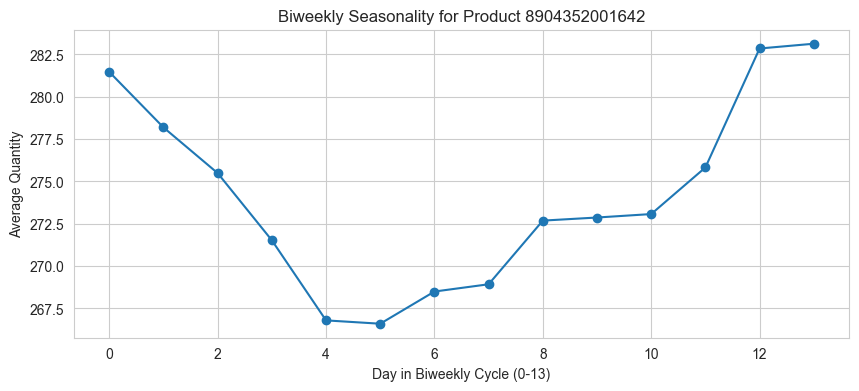

In [42]:
df = df.sort_values(['ean_code', 'order_date'])

df['lag_14'] = df.groupby('ean_code')['quantity'].shift(14)
df['roll_mean_14'] = df.groupby('ean_code')['quantity'].shift(1).rolling(window=14, min_periods=1).mean()

for prod in products_to_plot:
    prod_data = df[df['ean_code'] == prod].copy()
    prod_data['biweek_day'] = prod_data['order_date'].dt.dayofyear % 14
    biweekly_avg = prod_data.groupby('biweek_day')['quantity'].mean()

    biweekly_avg.plot(kind='line', marker='o', figsize=(10, 4),
                      title=f'Biweekly Seasonality for Product {prod}', grid=True)
    plt.xlabel('Day in Biweekly Cycle (0-13)')
    plt.ylabel('Average Quantity')
    plt.show()

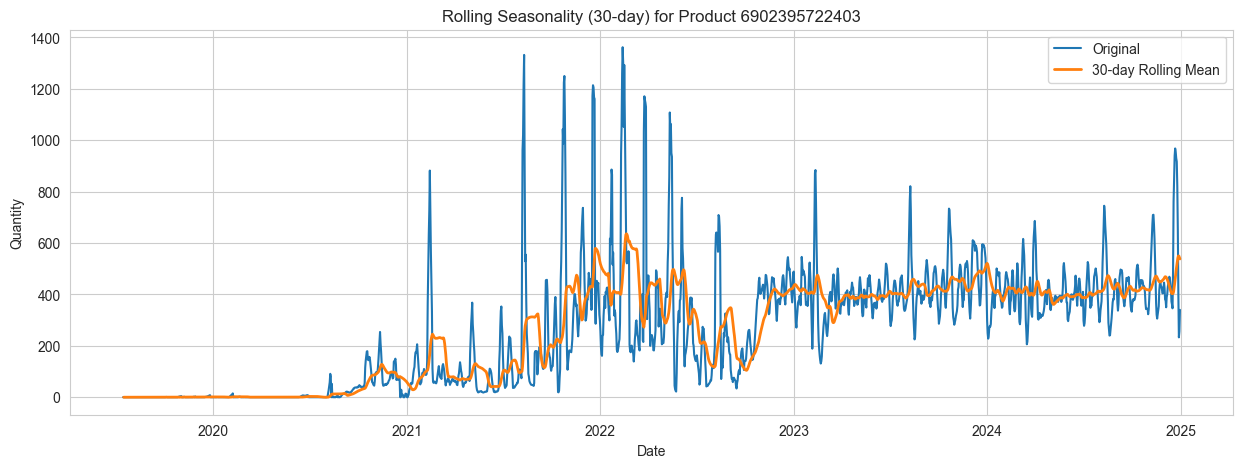

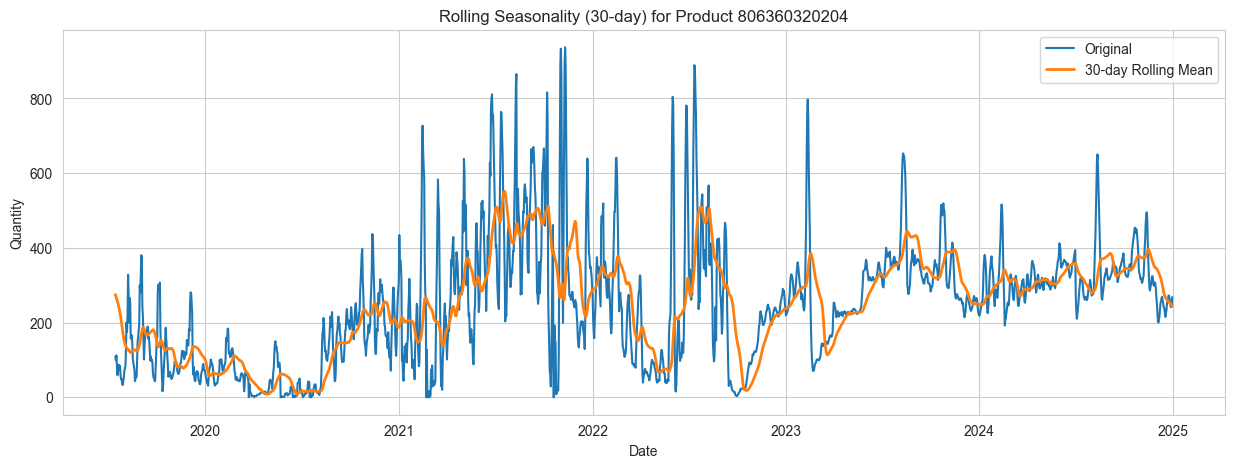

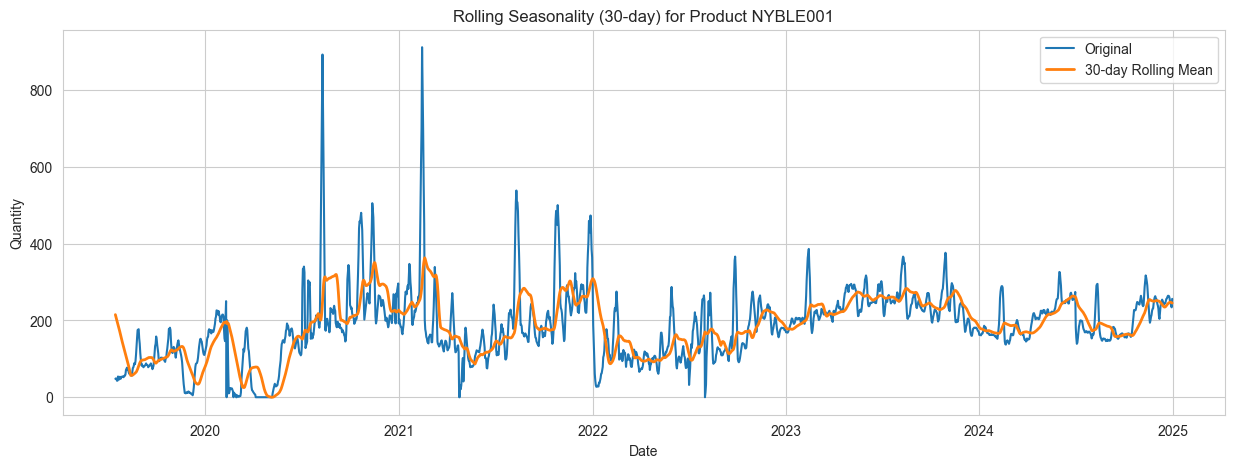

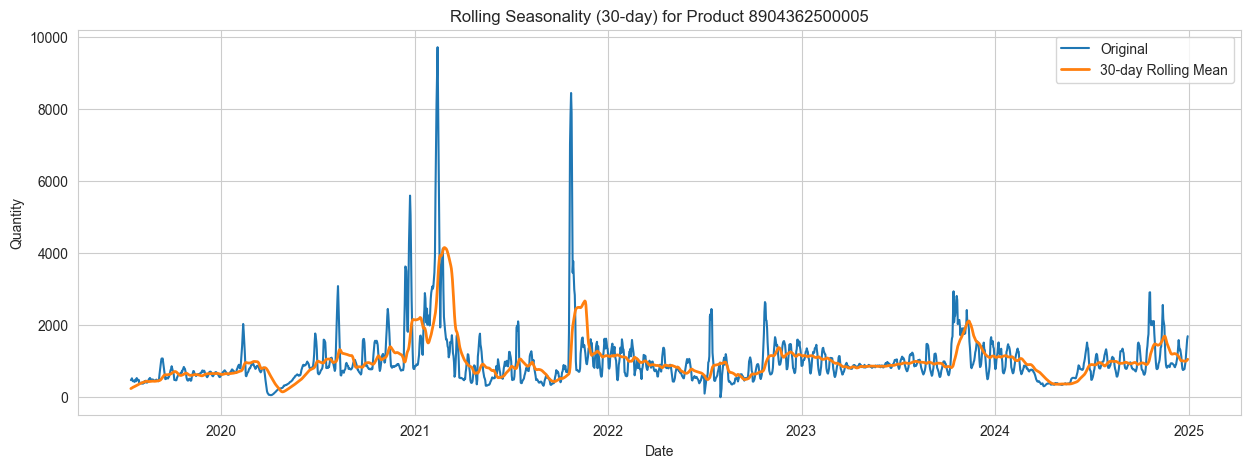

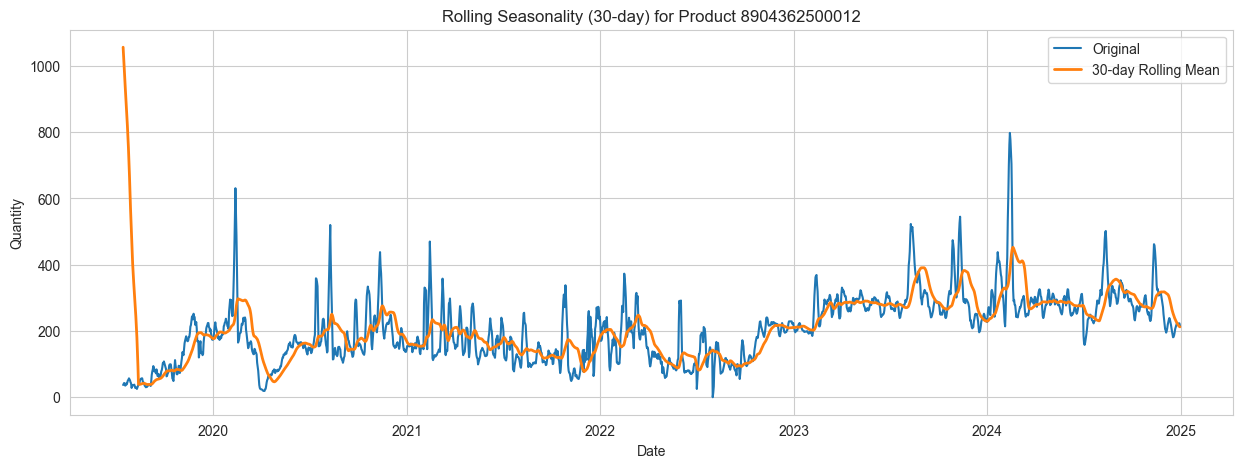

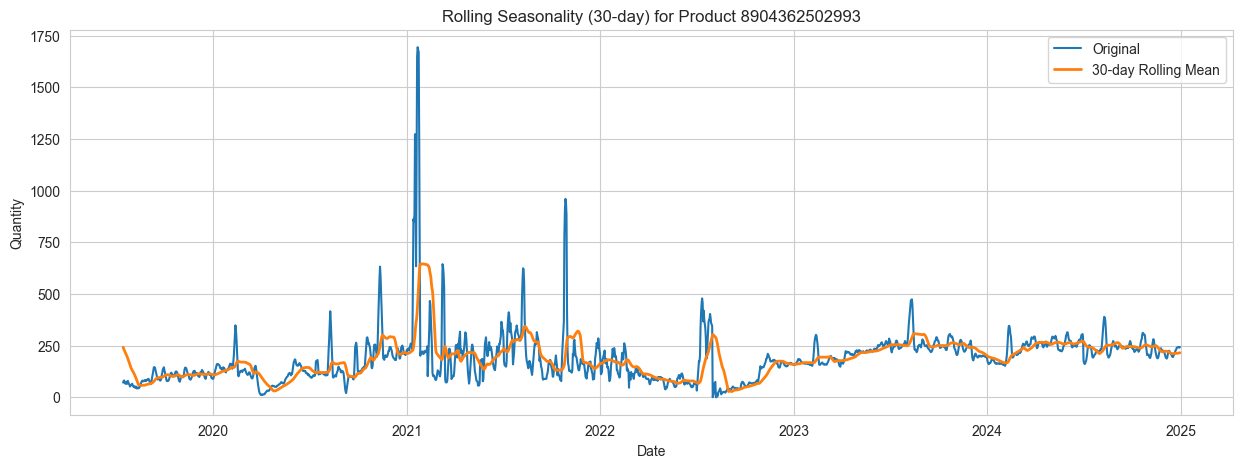

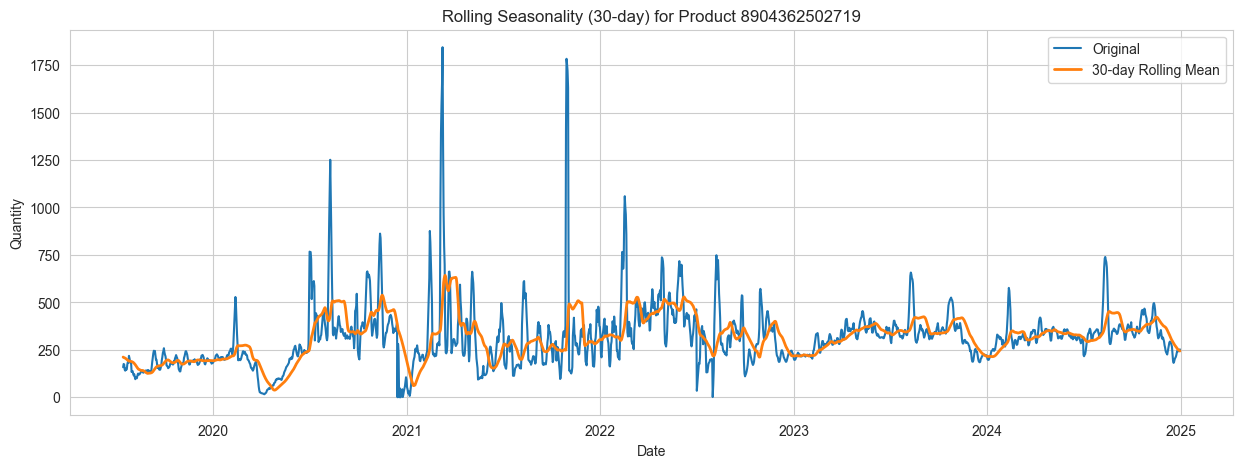

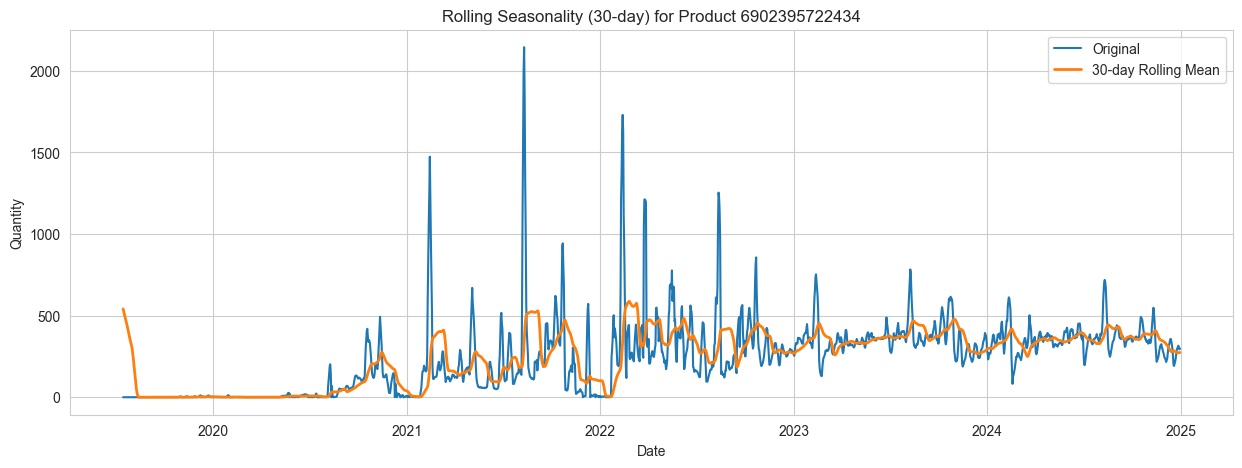

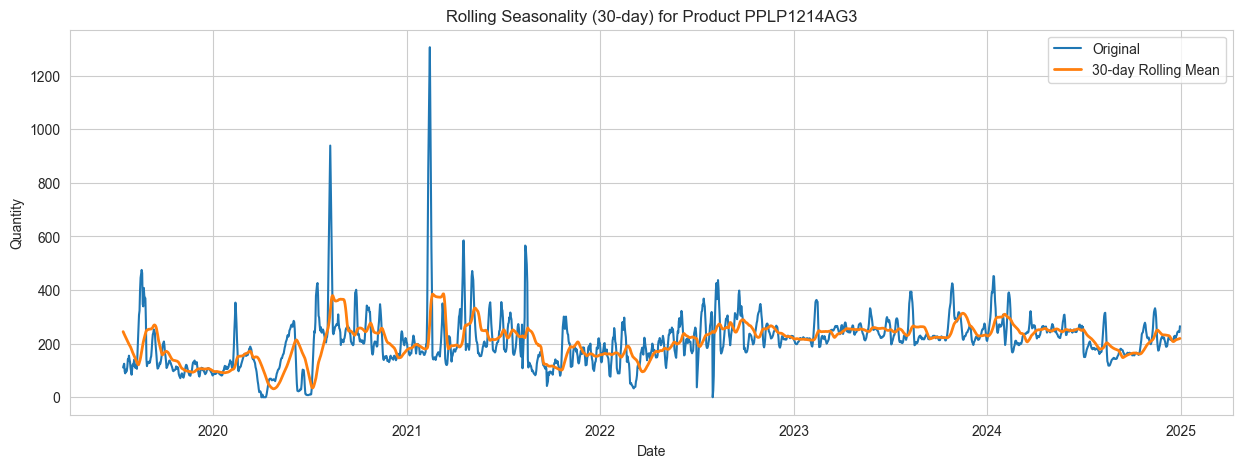

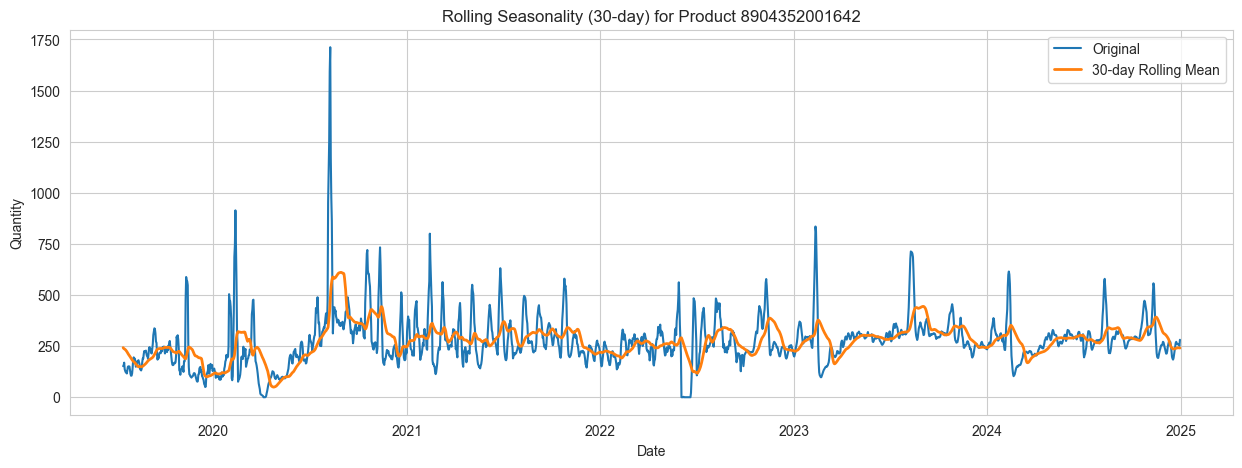

In [43]:
df['roll_mean_30'] = df.groupby('ean_code')['quantity'].shift(1).rolling(window=30, min_periods=1).mean()
df['roll_std_30'] = df.groupby('ean_code')['quantity'].shift(1).rolling(window=30, min_periods=1).std().fillna(0)

for prod in products_to_plot:
    prod_data = df[df['ean_code'] == prod]

    plt.figure(figsize=(15,5))
    plt.plot(prod_data['order_date'], prod_data['quantity'], label='Original')
    plt.plot(prod_data['order_date'], prod_data['roll_mean_30'], label='30-day Rolling Mean', linewidth=2)
    plt.title(f'Rolling Seasonality (30-day) for Product {prod}')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.show()


In [44]:
model_filename = 'Purplle_xgb_forecast_model.json'
xgb_model.save_model(model_filename)